# Split the codebook on training and validation parts

In [900]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras.layers import LSTM, Embedding, Bidirectional, BatchNormalization, SimpleRNN, Input, TimeDistributed
from keras import backend as K
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from scipy.spatial import distance
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.config.list_physical_devices('GPU')

[]

In [901]:
k = 8                       # number of information bits
N = 16                      # code length

nb_epoch = 2**18 
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
noise = True
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Eb = 1            # training-Eb/No
train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))).tolist()

In [902]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)        # std was changed to stddev 
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))    

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):   
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(int(K.not_equal(y_true, K.round(y_pred))))

def reshape_codebook(cb):
    global N
    global output_shape_test
    output_shape_test = tf.reshape(cb, (-1, N, 1))
    return output_shape_test

output_shape_test = (0, 0, 0)

In [903]:
def update_model(current_arch):
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)

    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)
    
    # Reshape layer
    reshape_layer = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape')]
    reshape = compose_model(reshape_layer)
    reshape.compile(optimizer=optimizer, loss=loss)

    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)
    
    
    # Define decoder
    
    if current_arch == 'dense-128-64-32':
        decoder_layers = [Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'dense-256-128-64-32':
        decoder_layers = [Dense(256, activation='relu', input_shape=(N,)),
                          Dense(128, activation='relu'),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-64':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-128':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
        
    elif current_arch == 'lstm-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(128, activation='relu', return_sequences=True), 
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
        
    elif current_arch == 'lstm-256-128-64-32':
        decoder_layers = [Lambda(reshape_codebook,
                            input_shape = (N,), output_shape = output_shape_test, name = 'reshape'),
                          LSTM(256, activation='relu', return_sequences=True),
                          LSTM(128, activation='relu', return_sequences=True),
                          LSTM(64, activation='relu', return_sequences=True), 
                          LSTM(32, activation='relu'),
                          Dense(k, activation='sigmoid')]
        decoder = compose_model(decoder_layers)
        decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])


    # Define model
#     if (LLR and noise):
#         model_layers = modulator_layers + noise_layers  + llr_layers + decoder_layers
#     elif (not LLR and noise):
#         model_layers = modulator_layers + noise_layers + decoder_layers
#     elif (not LLR and not noise):
#         model_layers = modulator_layers + decoder_layers

    if noise:
        model_layers = modulator_layers + noise_layers + decoder_layers
    else:
        model_layers = modulator_layers + decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    return model, decoder

In [904]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [905]:
def create_words(code):
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
        return x, d, A

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
        return x, d

### Create codebook

In [906]:
code = 'polar'              # type of code ('random' or 'polar')
codewords, inputs, log_vector = create_words(code)

In [907]:
log_vector

array([False, False, False, False, False, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True])

# With noise

In [908]:
noise = True

## i*train_size+i, train_size = 16

### Sptit codebook on train / validation parts

In [55]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


### Fit model

In [9]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 2s, sys: 1min 22s, total: 11min 24s
Wall time: 7min 47s


### Evaluate model

In [56]:
test_batch = 1000000

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 10
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((1,2**k,len(sigmas)),dtype=int)
nb_bits = np.zeros((1,2**k,len(sigmas)),dtype=int)
exp_descr = []

In [11]:
exp_descr.append('i*train_size+i')           # Add legend

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 16 elements

### Sptit codebook on train / validation parts

In [603]:
train_size = 16
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### Fit model

In [ ]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

### Evaluate model

In [229]:
exp_descr.append('first 16 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 32 elements

### Sptit codebook on train / validation parts

In [232]:
train_size = 32
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


### Fit model

In [233]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 6s, sys: 1min 24s, total: 11min 31s
Wall time: 7min 20s


### Evaluate model

In [234]:
exp_descr.append('first 32 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 64 elements

### Sptit codebook on train / validation parts

In [235]:
train_size = 64
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


### Fit model

In [236]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 8s, sys: 1min 23s, total: 11min 32s
Wall time: 7min 3s


### Evaluate model

In [237]:
exp_descr.append('first 64 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take first 128 elements

### Sptit codebook on train / validation parts

In [238]:
train_size = 128
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


### Fit model

In [239]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 58s, sys: 1min 31s, total: 12min 30s
Wall time: 7min 27s


### Evaluate model

In [240]:
exp_descr.append('first 128 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take 16 random elements

### Sptit codebook on train / validation parts

In [292]:
train_size = 16
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67]


### Fit model

In [293]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 14s, sys: 1min 22s, total: 11min 37s
Wall time: 8min 23s


### Evaluate model

In [294]:
exp_descr.append('random 16 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take 32 random elements

### Sptit codebook on train / validation parts

In [295]:
train_size = 32
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67, 103, 188, 53, 69, 141, 99, 153, 54, 121, 204, 177, 172, 56, 46, 186, 11]


### Fit model

In [296]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 9min 42s, sys: 1min 22s, total: 11min 4s
Wall time: 6min 46s


### Evaluate model

In [297]:
exp_descr.append('random 32 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take 64 random elements

### Sptit codebook on train / validation parts

In [298]:
train_size = 64
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67, 103, 188, 53, 69, 141, 99, 153, 54, 121, 204, 177, 172, 56, 46, 186, 11, 142, 68, 63, 183, 25, 75, 100, 240, 36, 96, 127, 86, 28, 24, 107, 74, 154, 119, 110, 43, 42, 30, 192, 97, 48, 219, 125, 98, 55, 237, 101, 158]


### Fit model

In [299]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 13s, sys: 1min 25s, total: 11min 39s
Wall time: 7min 5s


### Evaluate model

In [300]:
exp_descr.append('random 64 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take 128 random elements

### Sptit codebook on train / validation parts

In [572]:
train_size = 128
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67, 103, 188, 53, 69, 141, 99, 153, 54, 121, 204, 177, 172, 56, 46, 186, 11, 142, 68, 63, 183, 25, 75, 100, 240, 36, 96, 127, 86, 28, 24, 107, 74, 154, 119, 110, 43, 42, 30, 192, 97, 48, 219, 125, 98, 55, 237, 101, 158, 15, 139, 181, 32, 193, 14, 116, 226, 52, 236, 222, 224, 106, 21, 39, 115, 150, 229, 123, 201, 19, 29, 225, 164, 58, 80, 13, 1, 128, 254, 2, 94, 234, 44, 233, 59, 126, 130, 156, 159, 238, 62, 160, 51, 187, 34, 5, 255, 197, 246, 223, 37, 146, 184, 117, 185, 239, 231, 250, 241, 178, 31, 102, 175]


### Fit model

In [302]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 11min 6s, sys: 1min 32s, total: 12min 38s
Wall time: 7min 40s


### Evaluate model

In [303]:
exp_descr.append('random 128 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Take 86 random elements

### Sptit codebook on train / validation parts

In [415]:
train_size = 86
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67, 103, 188, 53, 69, 141, 99, 153, 54, 121, 204, 177, 172, 56, 46, 186, 11, 142, 68, 63, 183, 25, 75, 100, 240, 36, 96, 127, 86, 28, 24, 107, 74, 154, 119, 110, 43, 42, 30, 192, 97, 48, 219, 125, 98, 55, 237, 101, 158, 15, 139, 181, 32, 193, 14, 116, 226, 52, 236, 222, 224, 106, 21, 39, 115, 150, 229, 123, 201, 19, 29]


### Fit model

In [416]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 12min 5s, sys: 1min 32s, total: 13min 37s
Wall time: 10min 24s


### Evaluate model

In [417]:
exp_descr.append('random 86 elements')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

<ipython-input-43-128f880fe253>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-43-128f880fe253>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


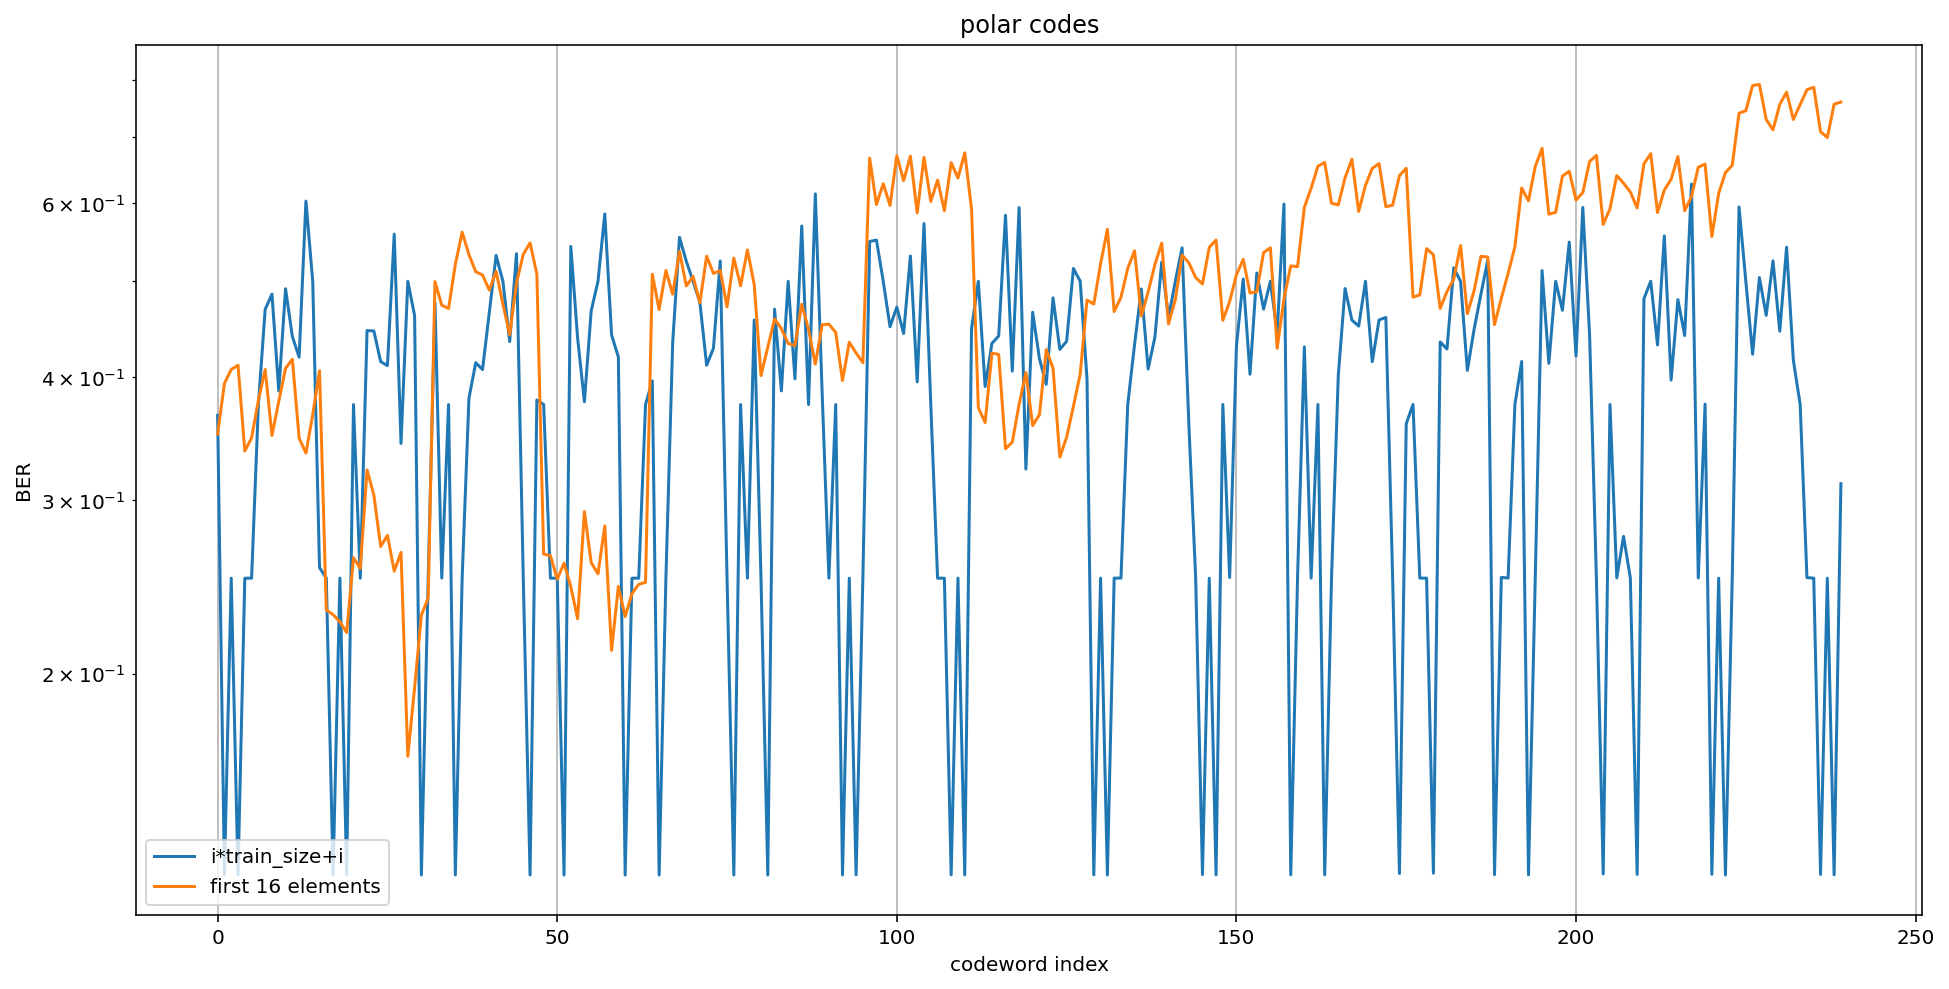

In [43]:
plt.figure(figsize = (16, 8))
for experiment in range(0, 2):
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

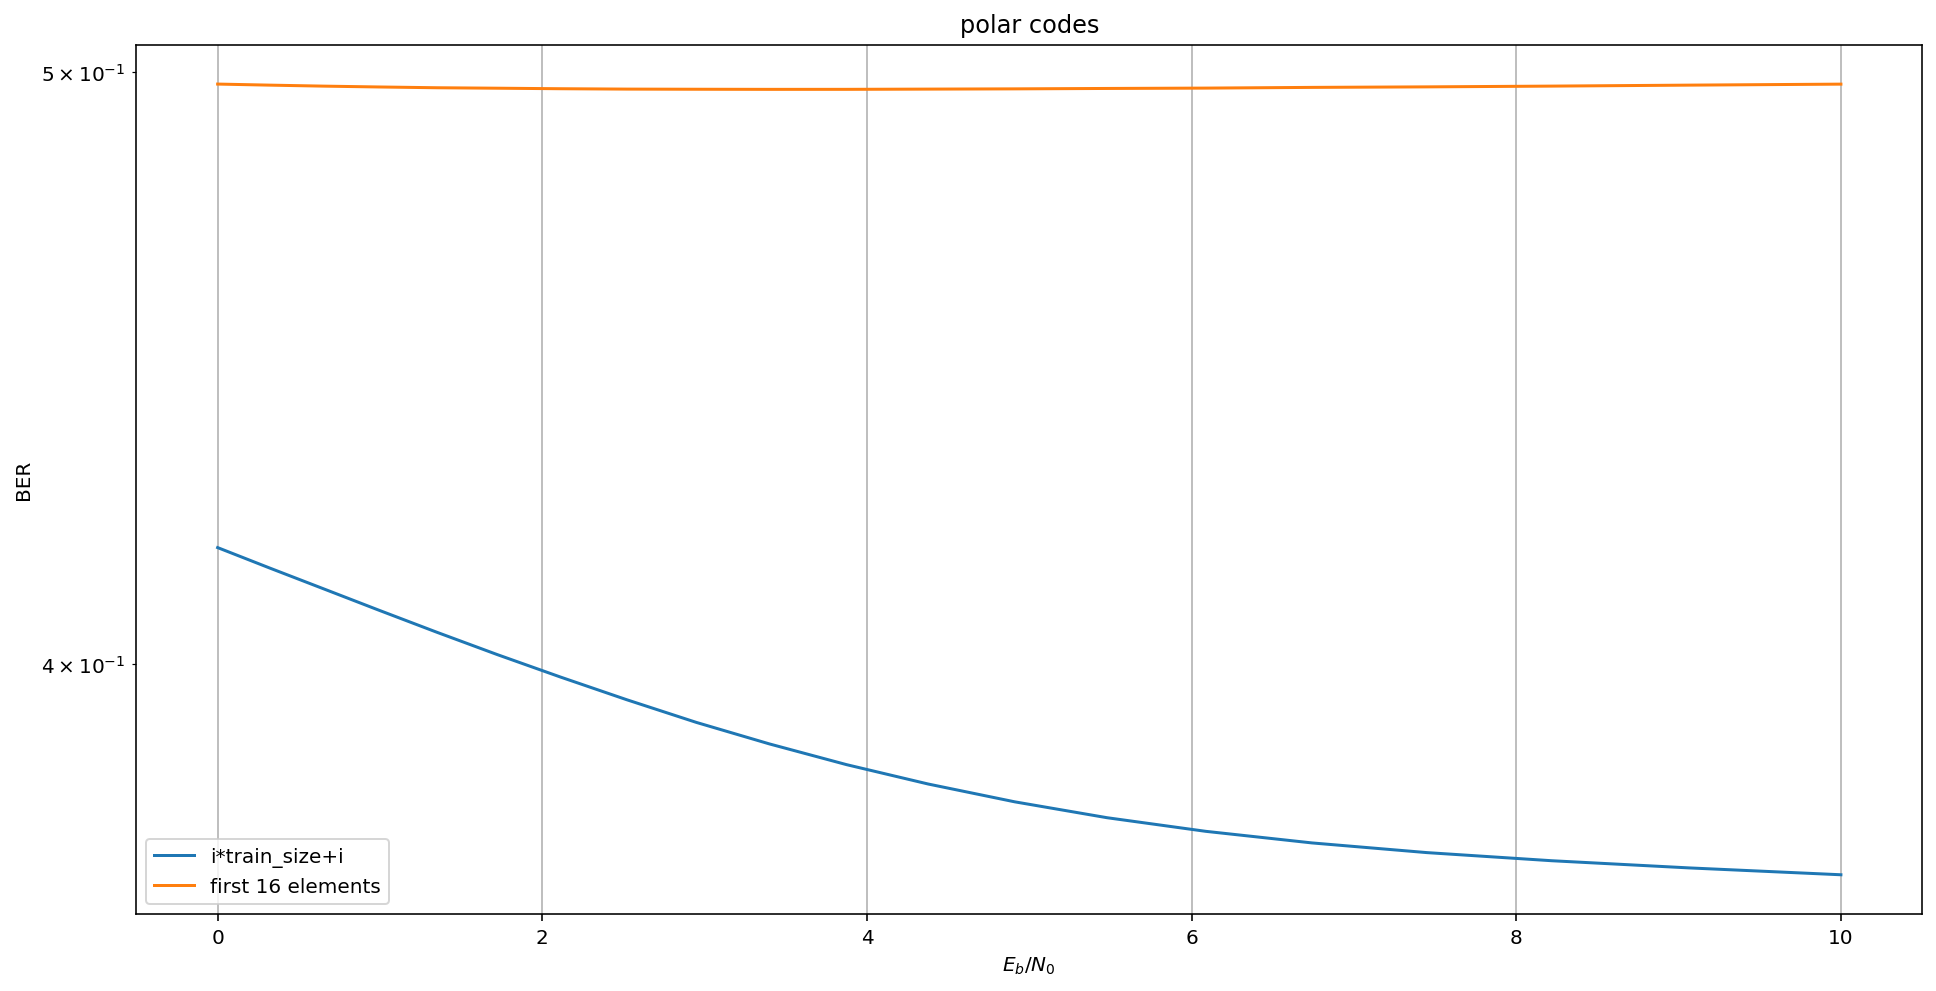

In [16]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(0, nb_bits.shape[0]):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

# Without noise

In [35]:
noise = False

In [36]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


In [ ]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

In [21]:
exp_descr.append('i*train_size+im w/o noise')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
#         y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(s_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## 1st 16

In [22]:
train_size = 16
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### Fit model

In [ ]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

### Evaluate model

In [24]:
exp_descr.append('first 16 elements, w/o noise')                                          # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
#         y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(s_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

<ipython-input-44-bd63c91ef97d>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
<ipython-input-44-bd63c91ef97d>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


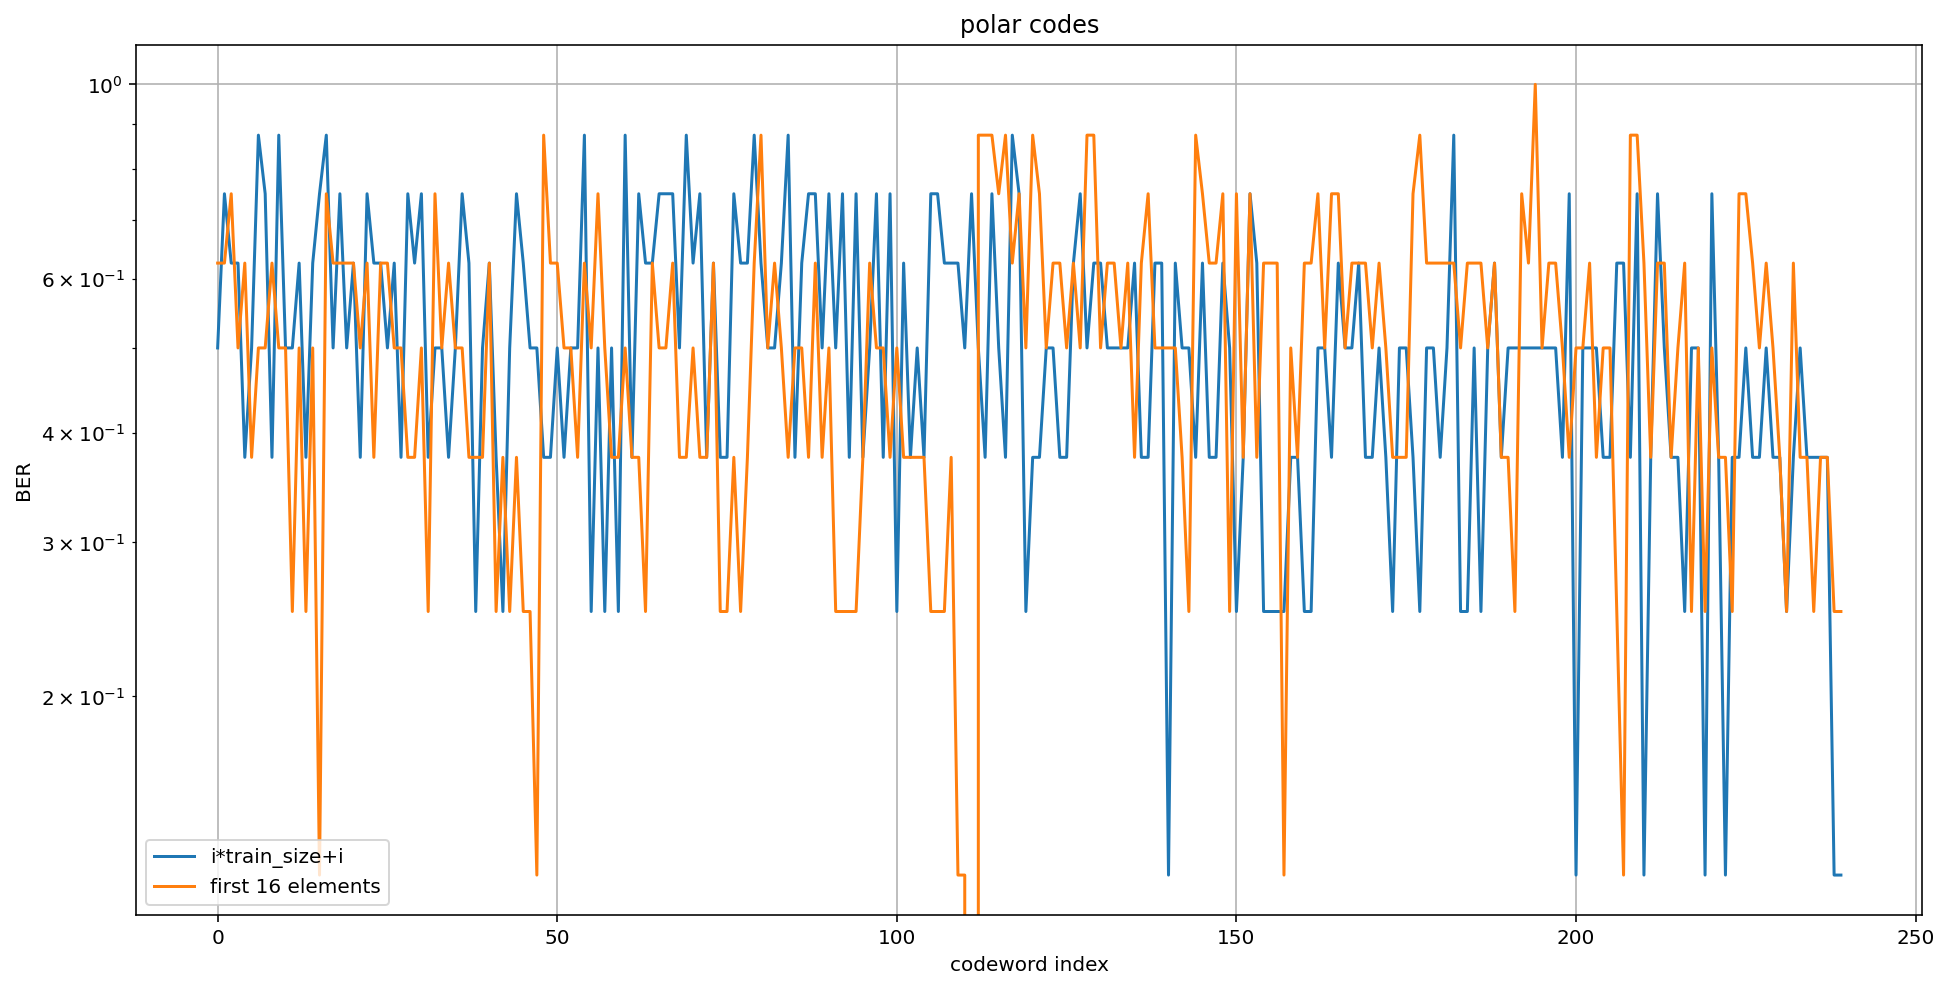

In [44]:
plt.figure(figsize = (16, 8))
for experiment in range(2, nb_bits.shape[0]):
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

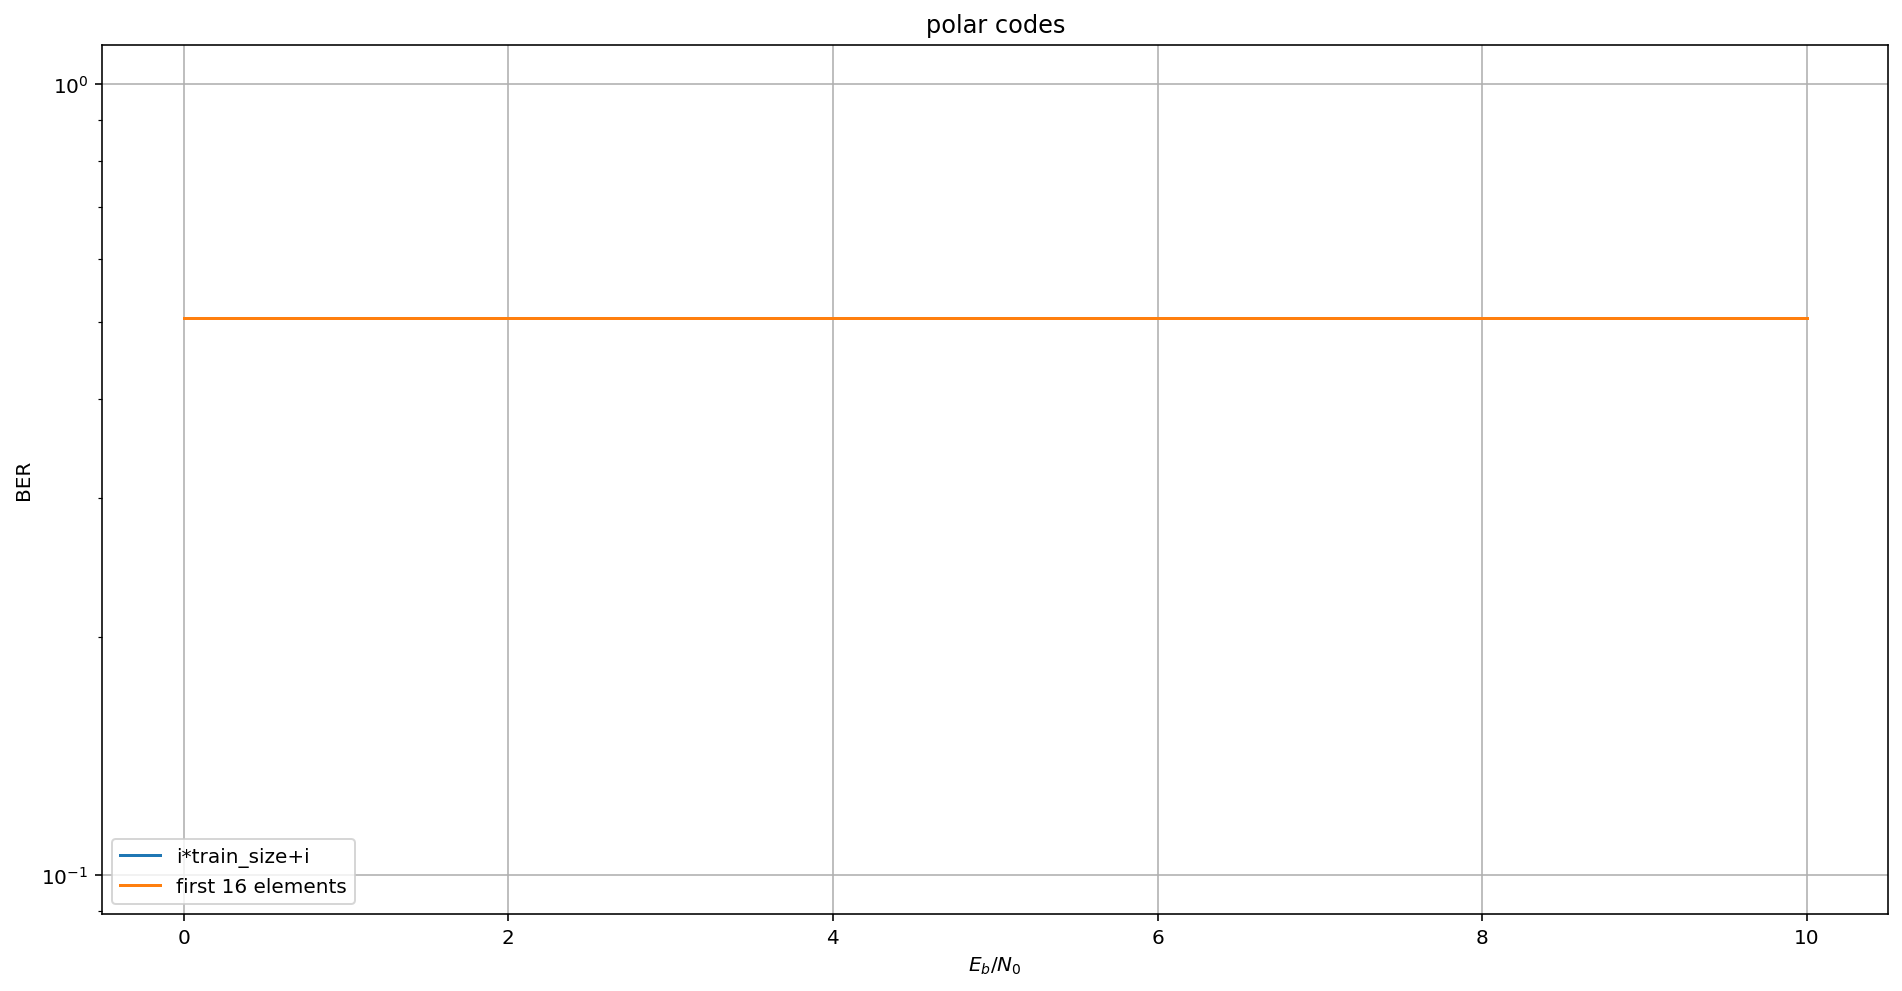

In [45]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(2, nb_bits.shape[0]):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

# Iterative picking

### With noise

In [57]:
noise = True

## Train on 16 codewords, test on 240

In [584]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


In [585]:
inputs_train.shape,  d_test.shape

((16, 8), (240, 8))

In [587]:
inputs_train.astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1]])

In [588]:
codewords_train

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True, False,  True, False, False,
        False, False, False,  True, False,  True, False],
       [False, False, False, False, False,  True, False,  True, False,
        False, False, False, False,  True, False,  True],
       [False, False, False, False,  True,  True, False, False, False,
        False, False, False,  True,  True, False, False],
       [False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False,  True,  True],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False,  True,  True, False],
       [False, False, False, False,  True, False, False,  True, False,
        False, False, Fals

### Fit model

In [60]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 53s, sys: 1min 29s, total: 12min 22s
Wall time: 9min 22s


### Evaluate model

In [61]:
exp_descr.append('iterative picking, 16 train / 240 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 29 codewords, test on 227

In [580]:
init_step_size = 8
idx = []
for i in range(29):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252]


In [581]:
inputs_train.shape,  d_test.shape

((29, 8), (227, 8))

In [589]:
inputs_train.astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1]])

### Fit model

In [64]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 9min 46s, sys: 1min 20s, total: 11min 6s
Wall time: 6min 54s


### Evaluate model

In [65]:
exp_descr.append('iterative picking, 29 train / 227 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 52 codewords, test on 204

In [257]:
init_step_size = 4
idx = []
for i in range(52):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255]


In [258]:
inputs_train.shape, d_test.shape

((52, 8), (204, 8))

### Fit model

In [68]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 9min 56s, sys: 1min 22s, total: 11min 18s
Wall time: 7min 22s


### Evaluate model

In [69]:
exp_descr.append('iterative picking, 52 train / 204 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 86 codewords, test on 170

In [909]:
init_step_size = 2
idx = []
for i in range(86):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255]


In [910]:
inputs_train.shape, d_test.shape

((86, 8), (170, 8))

### Fit model

In [911]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 12min 14s, sys: 1min 36s, total: 13min 50s
Wall time: 13min 51s


### Evaluate model

In [73]:
exp_descr.append('iterative picking, 86 train / 170 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Train on 30 codewords, test on 226

In [150]:
init_step_size = 8
idx = []
for i in range(29):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252]


In [151]:
inputs_train = np.vstack((inputs_train, d_test[-1]))
codewords_train = np.vstack((codewords_train, codewords[-1]))
d_test = np.delete(d_test, -1, axis = 0)

In [152]:
inputs_train.shape, codewords_train.shape, d_test.shape

((30, 8), (30, 16), (226, 8))

### Fit model

In [153]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 12min 14s, sys: 1min 32s, total: 13min 47s
Wall time: 15min 6s


### Evaluate model

In [154]:
# Same test / train codebook as in 29/227 case, but with last all-true
# codewornb_errorsrain CB
exp_descr.append('iterative picking, 30 train / 226 test')                     # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

## Plot test results

In [556]:
exp_descr

['iterative picking, 16 train / 240 test',
 'iterative picking, 29 train / 227 test',
 'iterative picking, 52 train / 204 test',
 'iterative picking, 86 train / 170 test',
 'iterative picking, 30 train / 226 test',
 'first 16 elements',
 'first 32 elements',
 'first 64 elements',
 'first 128 elements',
 'random 16 elements',
 'random 32 elements',
 'random 64 elements',
 'random 128 elements',
 'random 86 elements']

<ipython-input-720-99cc794e70d9>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


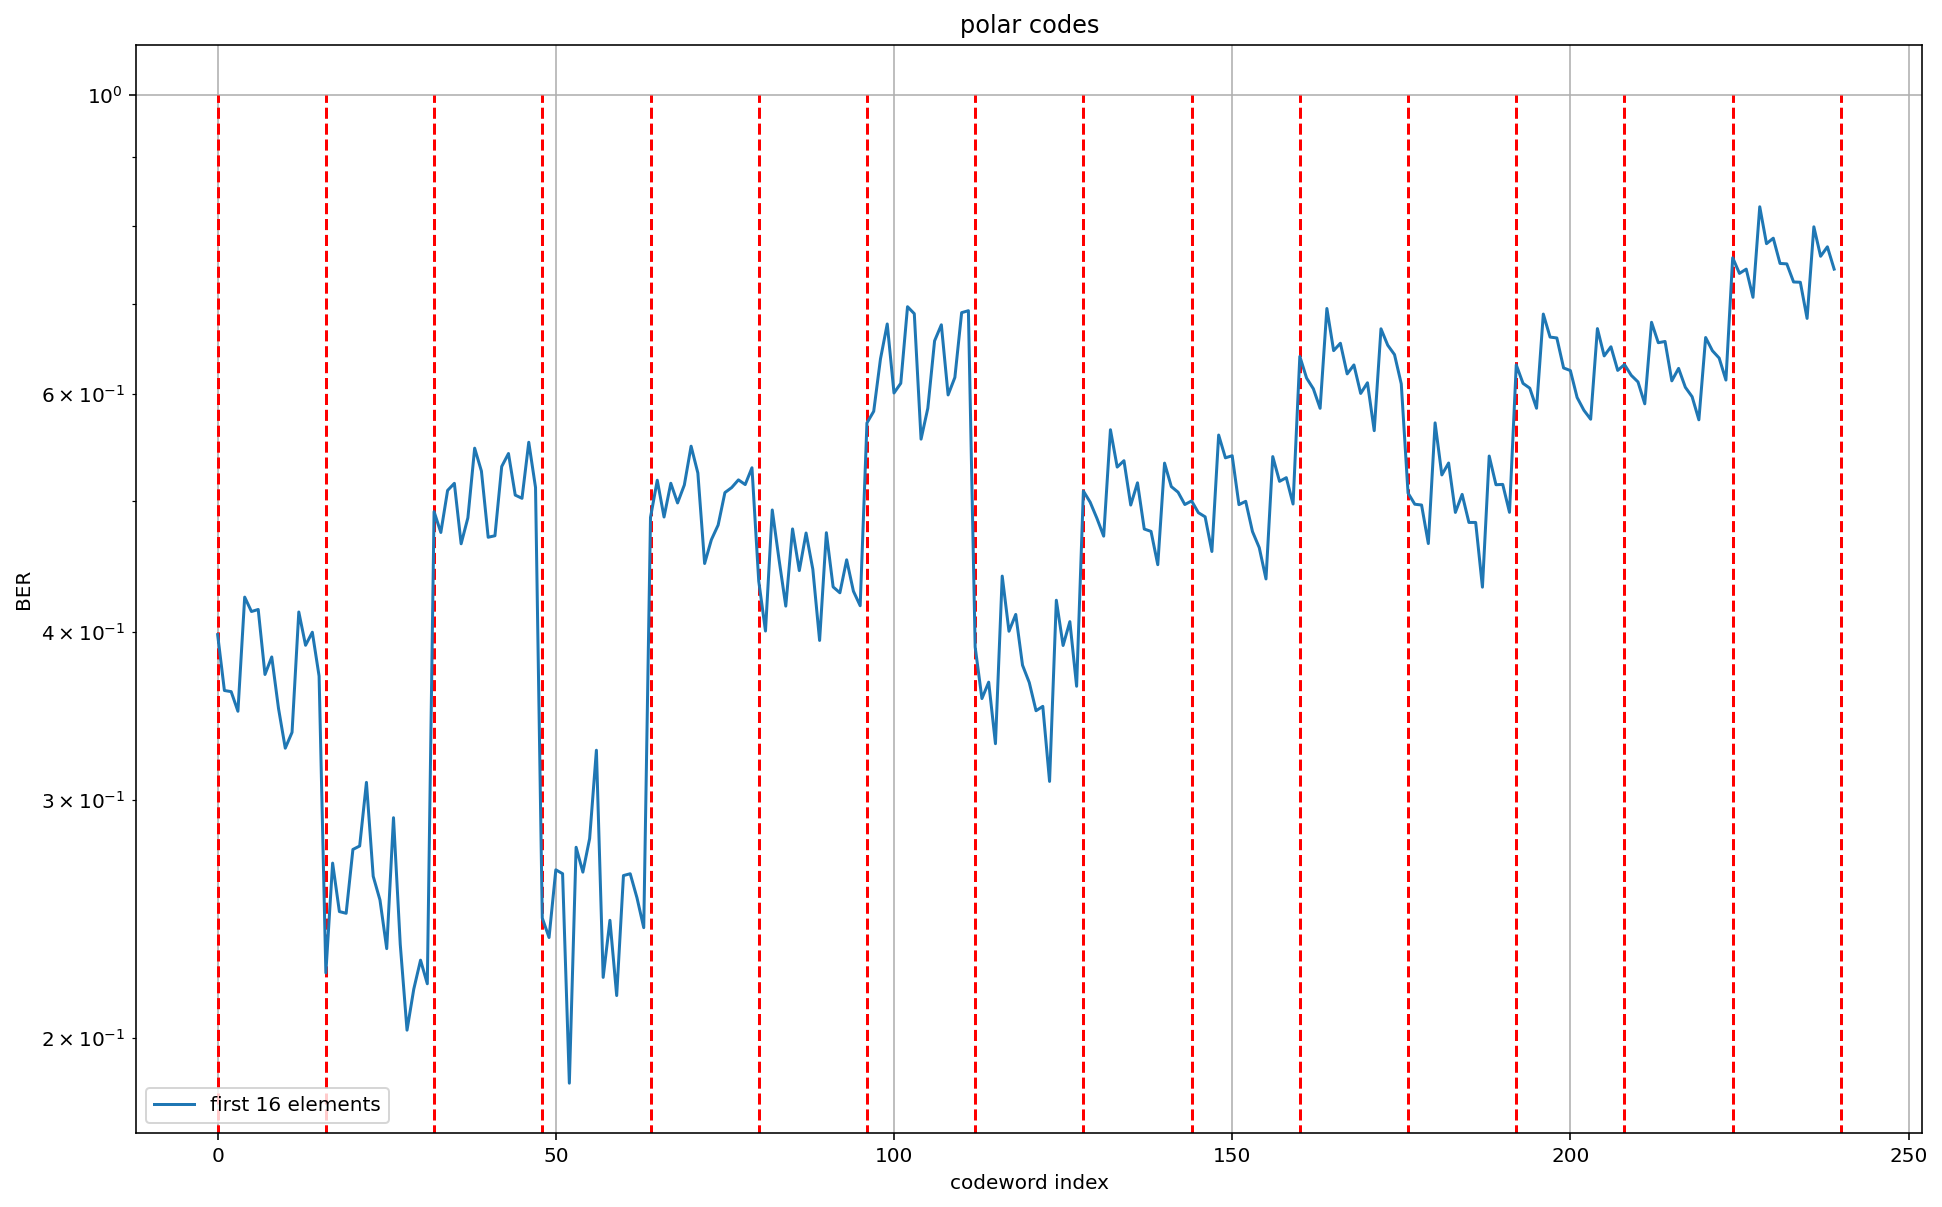

In [720]:
legend = []
plt.figure(figsize = (16, 10))
for experiment in [5]:
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
    legend.append(exp_descr[experiment])
plt.vlines([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240], 0, 1, linestyles='dashed', colors='red')
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

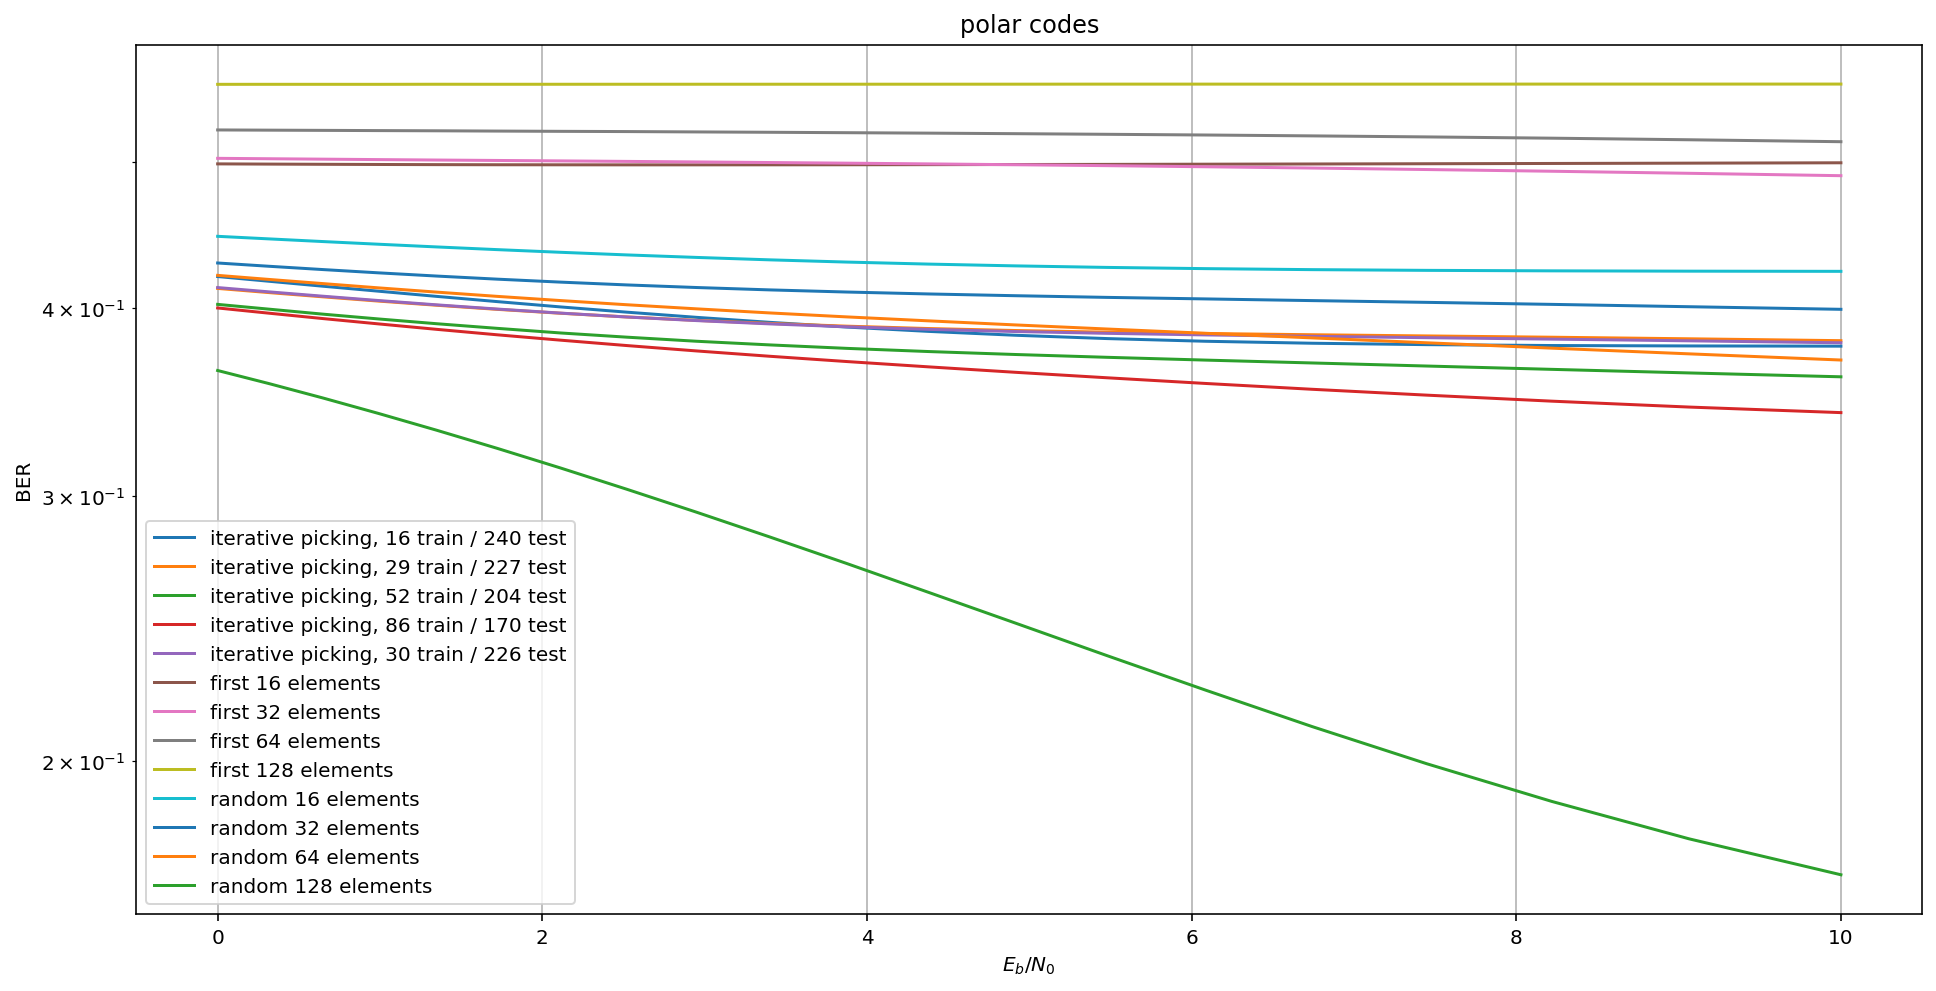

In [305]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in range(0, len(exp_descr)):
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

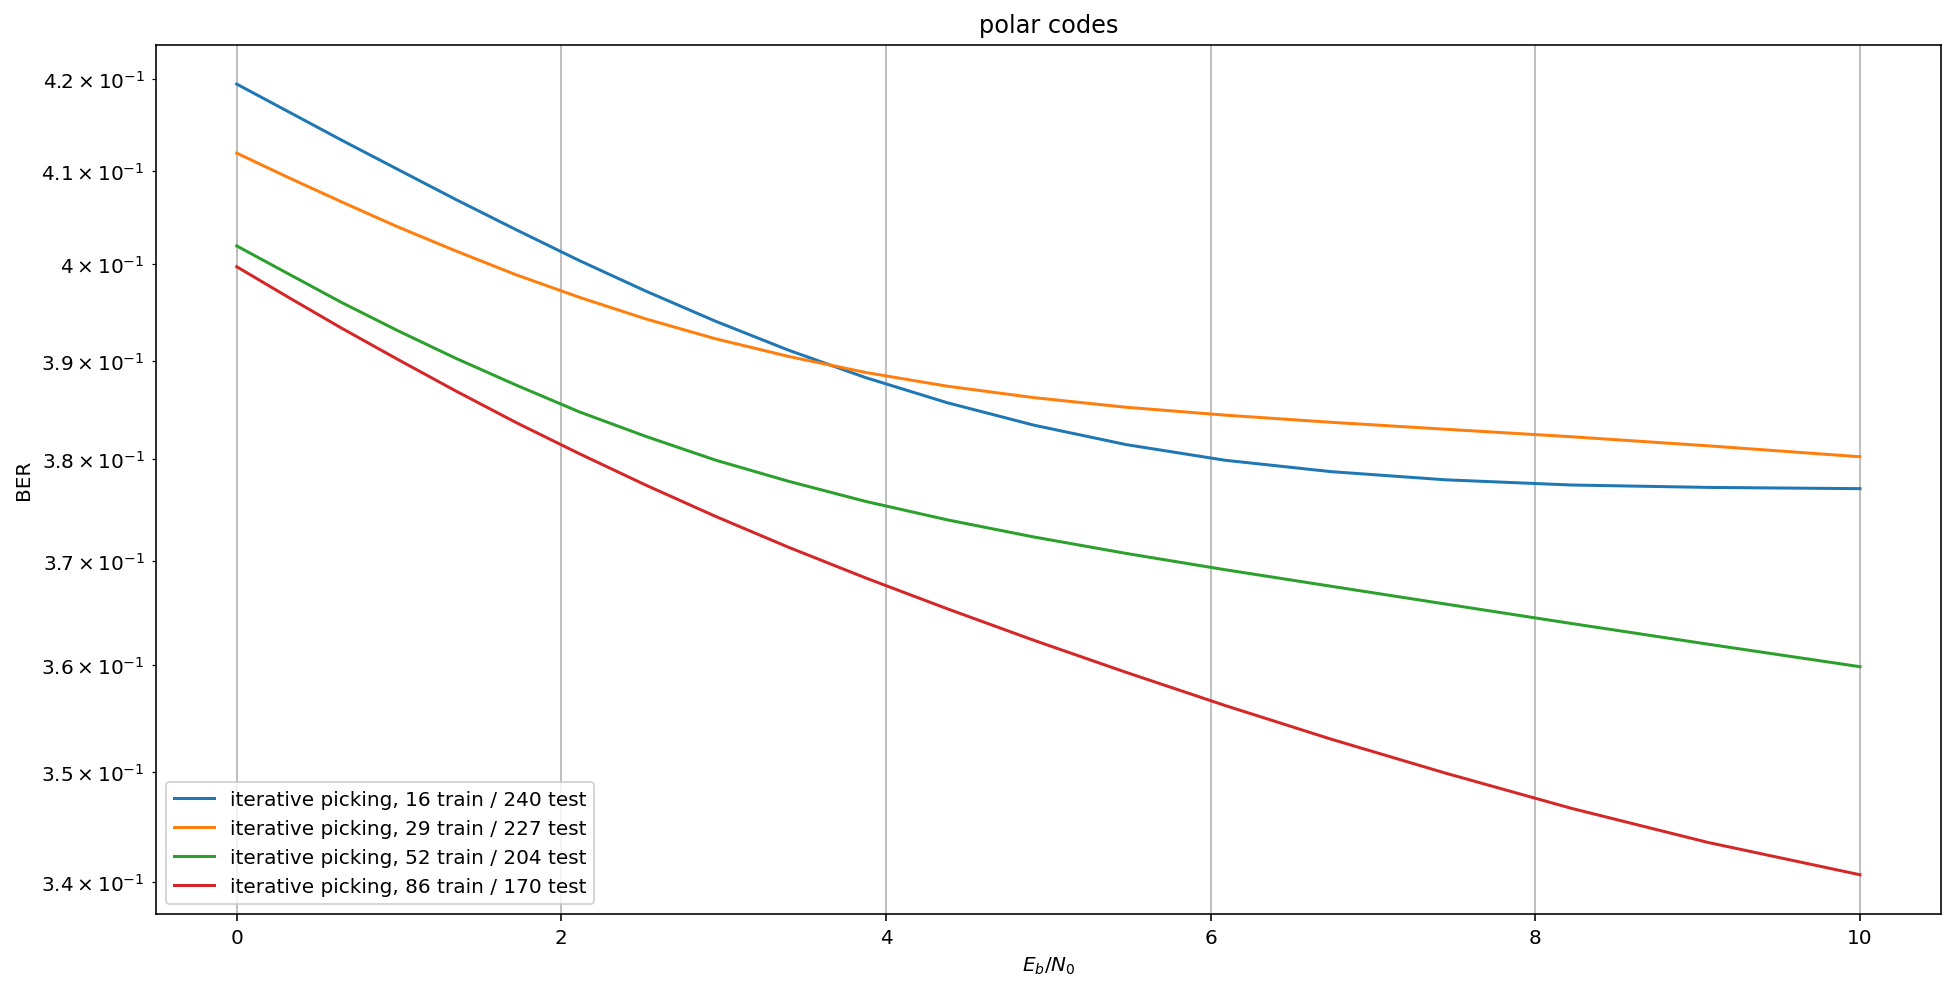

In [896]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

plt.figure(figsize = (16, 8))
for experiment in [0, 1, 2, 3]:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
plt.legend(exp_descr, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

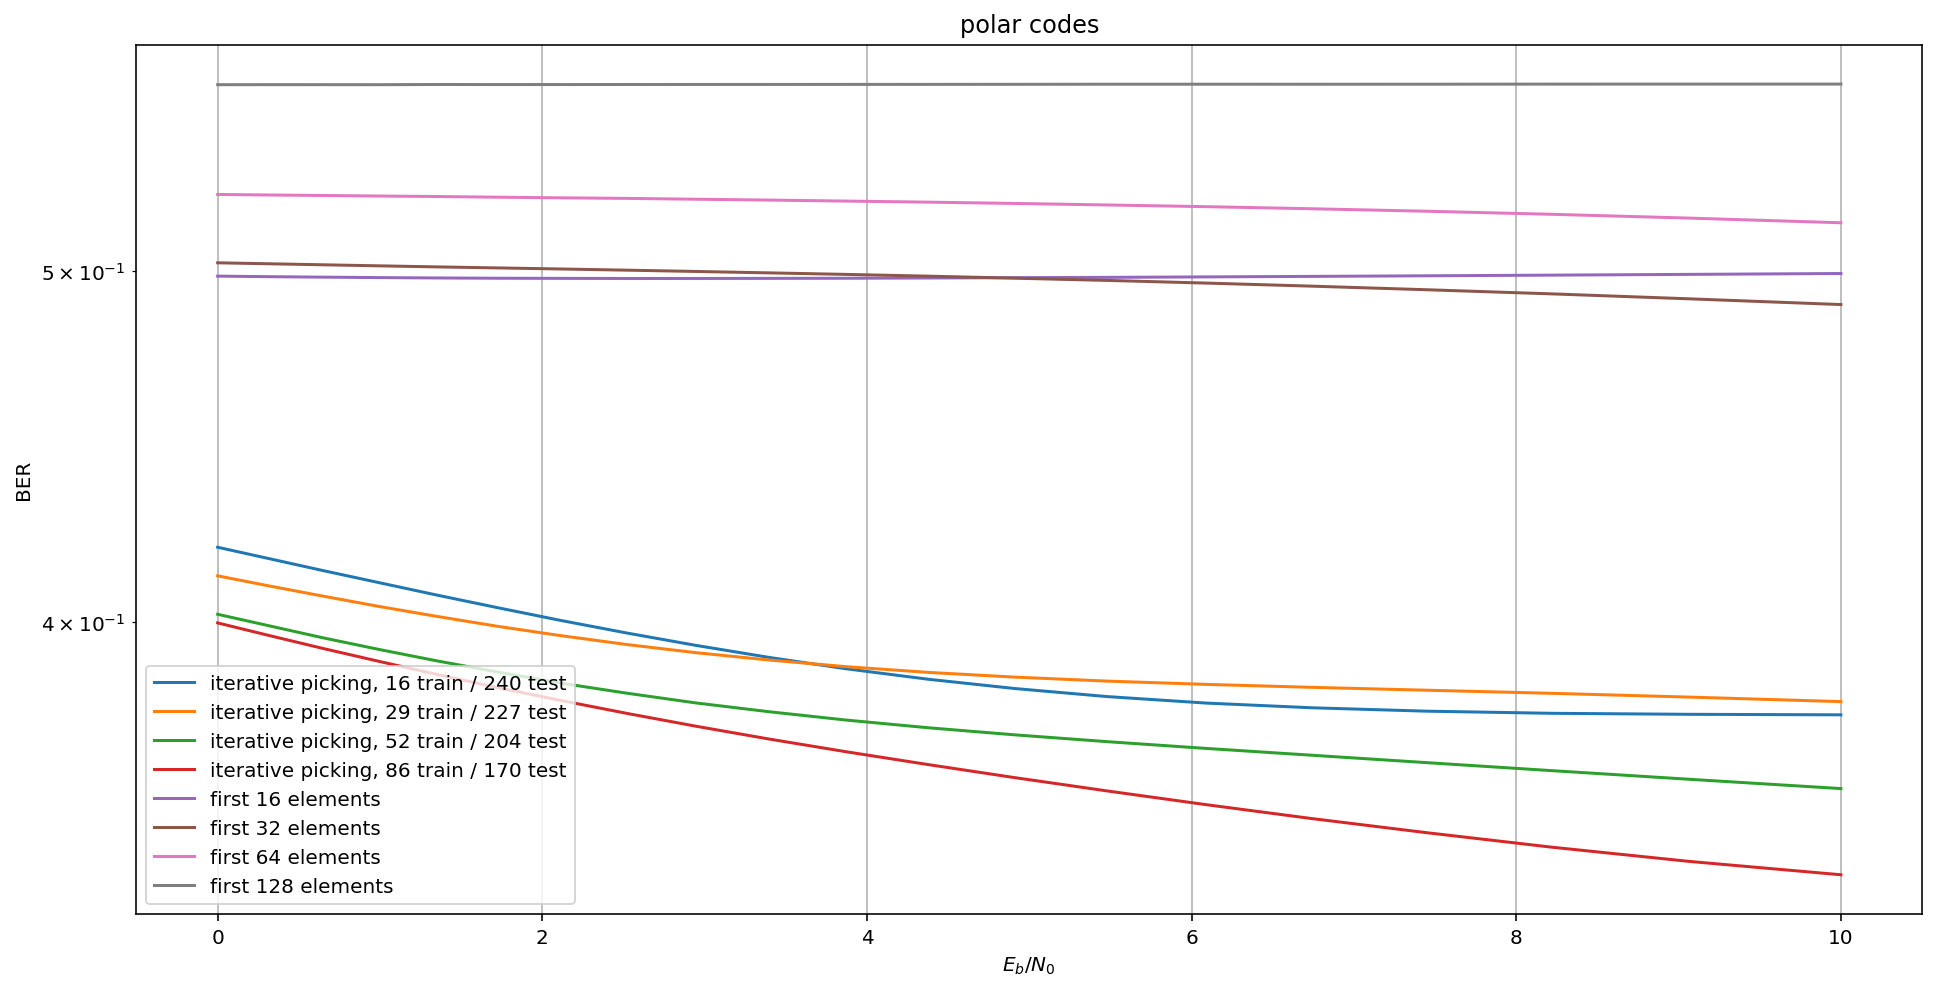

In [561]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)
legend = []
plt.figure(figsize = (16, 8))
for experiment in [0, 1, 2, 3, 5, 6, 7, 8]:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
    legend.append(exp_descr[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

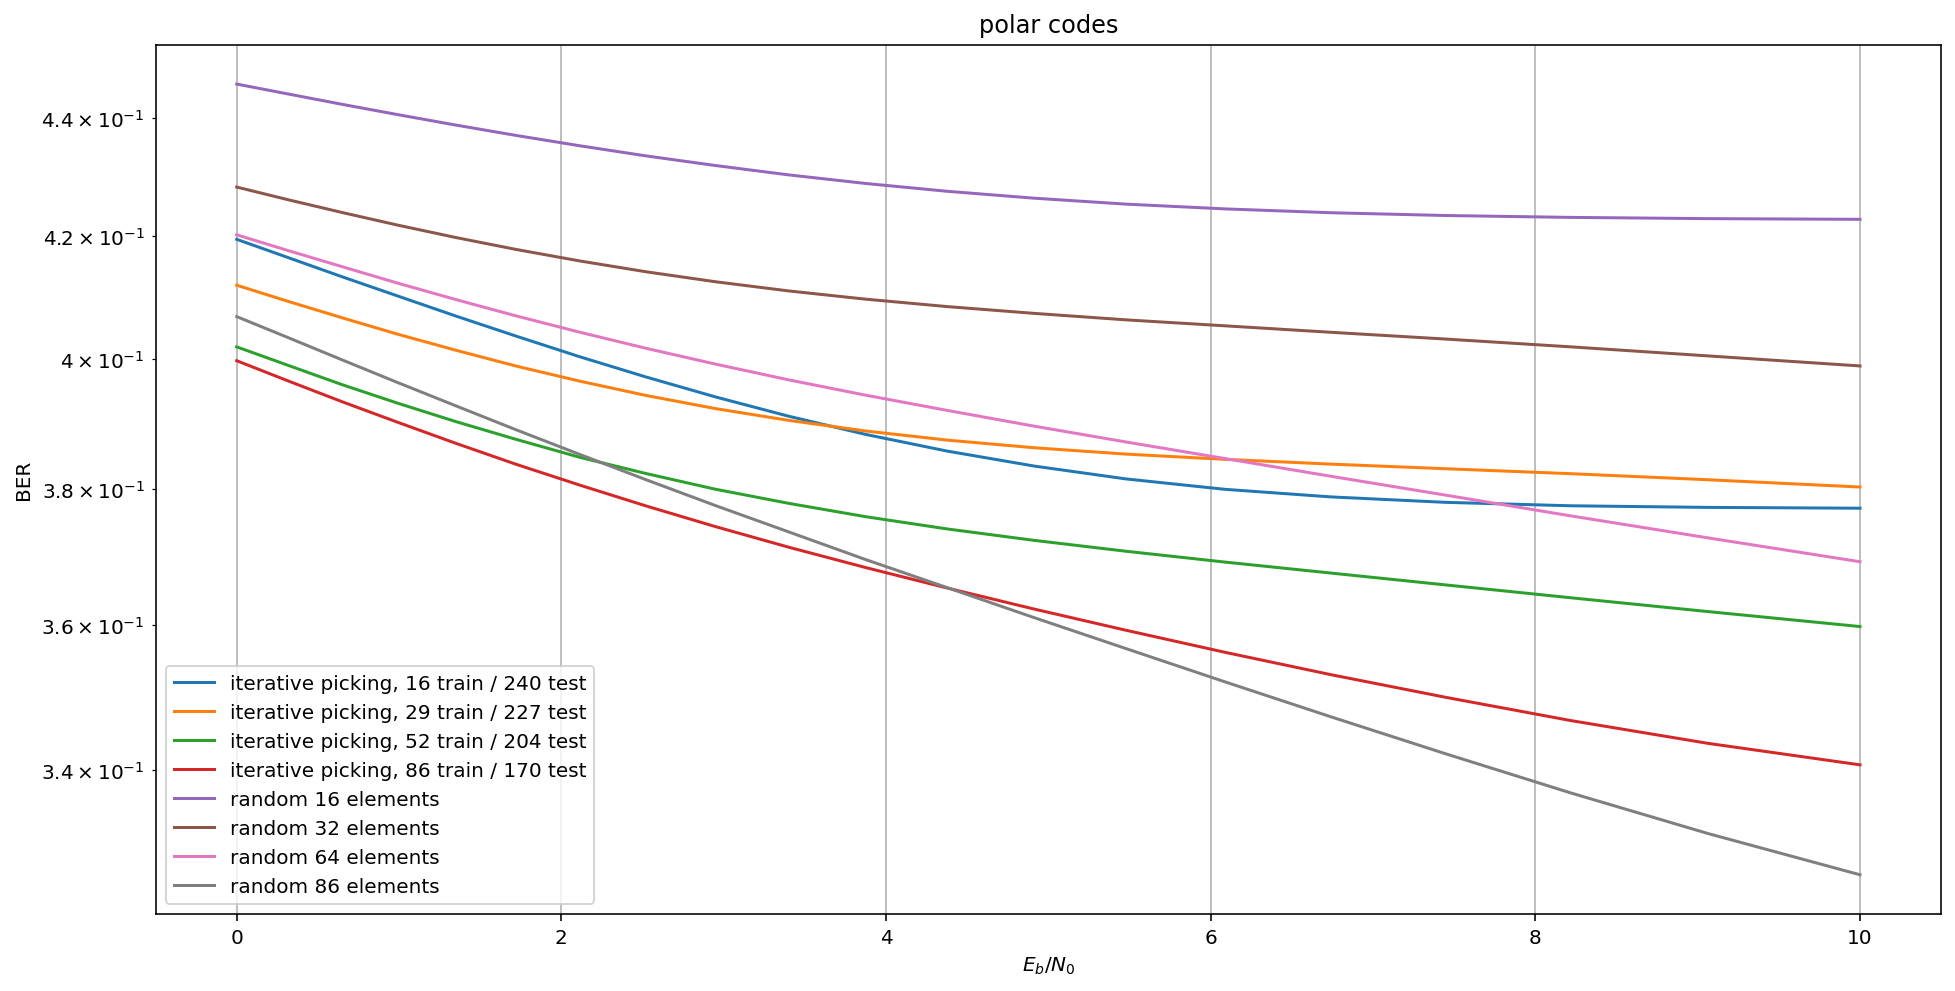

In [419]:
ber = np.sum(nb_errors, axis=1) / np.sum(nb_bits, axis=1)

legend = []

plt.figure(figsize = (16, 8))
for experiment in [0, 1, 2, 3, 9, 10, 11, 13]:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), ber[experiment])
    legend.append(exp_descr[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

In [531]:
exp_descr

['iterative picking, 16 train / 240 test',
 'iterative picking, 29 train / 227 test',
 'iterative picking, 52 train / 204 test',
 'iterative picking, 86 train / 170 test',
 'iterative picking, 30 train / 226 test',
 'first 16 elements',
 'first 32 elements',
 'first 64 elements',
 'first 128 elements',
 'random 16 elements',
 'random 32 elements',
 'random 64 elements',
 'random 128 elements',
 'random 86 elements']

# Save results to the files

In [888]:
# number of errors in .npy format
np.save(f'codebook/iterative-picking/{nb_epoch}-train_{test_batch}-test/errors_16-240_29-227_52-204_86-170_30-226', nb_errors)

In [889]:
# number of test bits in .npy format
np.save(f'codebook/iterative-picking/{nb_epoch}-train_{test_batch}-test/bits_16-240_29-227_52-204_86-170_30-226', nb_bits)

In [890]:
# experimet descriptions (legend)
with open(f'codebook/iterative-picking/{nb_epoch}-train_{test_batch}-test/exp_descr.txt', 'w') as filehandle:
    for listitem in exp_descr:
        filehandle.write('%s\n' % listitem)

In [393]:
exp_descr

['iterative picking, 16 train / 240 test',
 'iterative picking, 29 train / 227 test',
 'iterative picking, 52 train / 204 test',
 'iterative picking, 86 train / 170 test',
 'iterative picking, 30 train / 226 test',
 'first 16 elements',
 'first 32 elements',
 'first 64 elements',
 'first 128 elements',
 'random 16 elements',
 'random 32 elements',
 'random 64 elements',
 'random 128 elements']

In [273]:
np.savetxt('codebook/inputs.txt', inputs, fmt='%i')

In [274]:
np.savetxt('codebook/codewords.txt', codewords, fmt='%i')

# Analysis

In [566]:
d_test.shape, inputs_train.shape

((240, 8), (16, 8))

(array([3., 3., 2., 3., 3., 2., 3., 3., 2., 3., 3., 2., 3., 3., 2., 3., 3.,
        2., 3., 3., 2., 3., 3., 2., 3., 3., 2., 3., 3., 2., 3., 3.]),
 array([  0.     ,   7.96875,  15.9375 ,  23.90625,  31.875  ,  39.84375,
         47.8125 ,  55.78125,  63.75   ,  71.71875,  79.6875 ,  87.65625,
         95.625  , 103.59375, 111.5625 , 119.53125, 127.5    , 135.46875,
        143.4375 , 151.40625, 159.375  , 167.34375, 175.3125 , 183.28125,
        191.25   , 199.21875, 207.1875 , 215.15625, 223.125  , 231.09375,
        239.0625 , 247.03125, 255.     ]),
 <BarContainer object of 32 artists>)

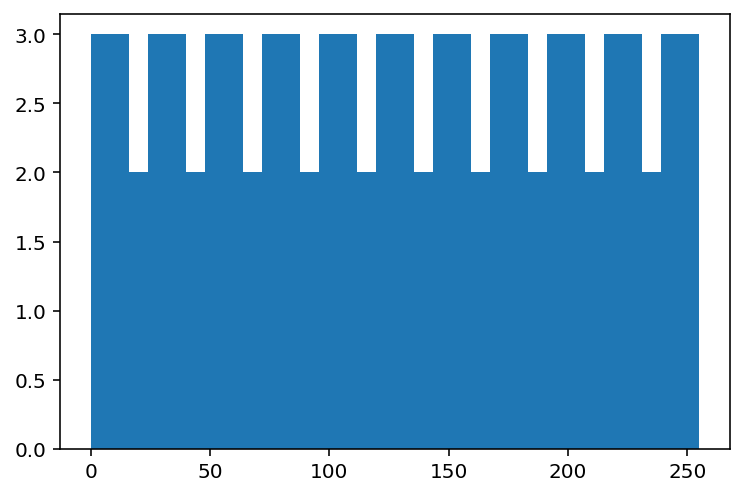

In [952]:
#check how train CW indicies are distributed
plt.hist(idx, bins=32)

првоерить на ldpc

## Find number of unique linear combinations

### Iterative 86

In [577]:
init_step_size = 2
idx = []
for i in range(86):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255]


In [520]:
test = []
for i in range(inputs_train.shape[0]):
    for j in range(inputs_train.shape[0]):
        test.append(inputs_train[i] ^ inputs_train[j])
test = np.array(test)

In [521]:
np.unique(test, axis=0).shape

(240, 8)

### Random 86

In [590]:
train_size = 86
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67, 103, 188, 53, 69, 141, 99, 153, 54, 121, 204, 177, 172, 56, 46, 186, 11, 142, 68, 63, 183, 25, 75, 100, 240, 36, 96, 127, 86, 28, 24, 107, 74, 154, 119, 110, 43, 42, 30, 192, 97, 48, 219, 125, 98, 55, 237, 101, 158, 15, 139, 181, 32, 193, 14, 116, 226, 52, 236, 222, 224, 106, 21, 39, 115, 150, 229, 123, 201, 19, 29]


In [523]:
test = []
for i in range(inputs_train.shape[0]):
    for j in range(inputs_train.shape[0]):
        test.append(inputs_train[i] ^ inputs_train[j])
test = np.array(test)

In [524]:
np.unique(test, axis=0).shape

(256, 8)

### Iterative 52

In [528]:
init_step_size = 4
idx = []
for i in range(52):
    idx.append(int(i*init_step_size+i))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255]


In [529]:
test = []
for i in range(inputs_train.shape[0]):
    for j in range(inputs_train.shape[0]):
        test.append(inputs_train[i] ^ inputs_train[j])
test = np.array(test)

In [530]:
np.unique(test, axis=0).shape

(192, 8)

### Random 52

In [538]:
train_size = 52
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67, 103, 188, 53, 69, 141, 99, 153, 54, 121, 204, 177, 172, 56, 46, 186, 11, 142, 68, 63, 183, 25, 75, 100, 240, 36, 96, 127, 86, 28, 24, 107, 74, 154, 119, 110, 43]


In [539]:
test = []
for i in range(inputs_train.shape[0]):
    for j in range(inputs_train.shape[0]):
        test.append(inputs_train[i] ^ inputs_train[j])
test = np.array(test)

In [540]:
np.unique(test, axis=0).shape

(256, 8)

### Iterative 16

In [541]:
train_size = 16
idx = []
for i in range(train_size):
    idx.append(i*train_size+i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255]


In [542]:
test = []
for i in range(inputs_train.shape[0]):
    for j in range(inputs_train.shape[0]):
        test.append(inputs_train[i] ^ inputs_train[j])
test = np.array(test)

In [543]:
np.unique(test, axis=0).shape

(16, 8)

### Random 16

In [544]:
train_size = 16
np.random.seed(seed=1337)
idx = list(np.random.choice(2**k, size=train_size, replace=False))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [113, 35, 87, 41, 166, 112, 165, 124, 85, 120, 89, 168, 169, 190, 200, 67]


In [545]:
test = []
for i in range(inputs_train.shape[0]):
    for j in range(inputs_train.shape[0]):
        test.append(inputs_train[i] ^ inputs_train[j])
test = np.array(test)

In [546]:
np.unique(test, axis=0).shape

(97, 8)

# Tasks

1. Define why some CW groups can be decoded better, than others
2. Repeat results with other structured codes (LDPC, BCH)
3. Evaluate the performance of single-bit classifier
4. Repeat decoding methods from literature (Tanner, syndrom-based decoder)

# Train on first 16 elements. Define why NN can predict some codeword groups better, than others

### Sptit codebook on train / validation parts

In [606]:
train_size = 16
idx = list(np.arange(train_size, dtype=int))
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


### Fit model

In [607]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 4s, sys: 1min 23s, total: 11min 27s
Wall time: 7min 50s


### Make predictions

In [766]:
predictions = np.zeros((d_test.shape[0], k), dtype = bool)
u_test = np.zeros((d_test.shape[0], N), dtype=bool)
u_test[:, log_vector] = d_test
print(f'CW #,  predicted        |  inputs')
for i in range(0, u_test.shape[0]):
    x_test = polar_transform_iter(u_test[i])
    s_test = -2*x_test + 1
    y_test = s_test + sigmas[-1]*np.random.standard_normal(s_test.shape)
    predictions[i] = np.round(decoder.predict(np.reshape(y_test, (1, 16)), batch_size=1))
    print(f'CW:{i+16} {predictions[i].astype(int)} | {d_test[i].astype(int)}')

CW #,  predicted        |  inputs
CW:16 [0 0 0 0 0 1 0 0] | [0 0 0 1 0 0 0 0]
CW:17 [0 0 0 0 1 1 1 0] | [0 0 0 1 0 0 0 1]
CW:18 [0 0 0 0 1 1 0 0] | [0 0 0 1 0 0 1 0]
CW:19 [0 0 0 0 1 1 1 0] | [0 0 0 1 0 0 1 1]
CW:20 [0 0 0 0 0 1 1 0] | [0 0 0 1 0 1 0 0]
CW:21 [0 0 0 0 1 0 1 0] | [0 0 0 1 0 1 0 1]
CW:22 [0 0 0 0 1 1 1 1] | [0 0 0 1 0 1 1 0]
CW:23 [0 0 0 0 1 1 1 0] | [0 0 0 1 0 1 1 1]
CW:24 [0 0 0 0 1 1 0 1] | [0 0 0 1 1 0 0 0]
CW:25 [0 0 0 0 1 1 1 0] | [0 0 0 1 1 0 0 1]
CW:26 [0 0 0 0 1 1 1 0] | [0 0 0 1 1 0 1 0]
CW:27 [0 0 0 0 1 1 1 0] | [0 0 0 1 1 0 1 1]
CW:28 [0 0 0 0 1 1 0 0] | [0 0 0 1 1 1 0 0]
CW:29 [0 0 0 0 1 1 0 0] | [0 0 0 1 1 1 0 1]
CW:30 [0 0 0 0 0 1 1 0] | [0 0 0 1 1 1 1 0]
CW:31 [0 0 0 0 1 1 1 0] | [0 0 0 1 1 1 1 1]
CW:32 [0 0 0 0 1 0 1 0] | [0 0 1 0 0 0 0 0]
CW:33 [0 0 0 0 0 0 0 1] | [0 0 1 0 0 0 0 1]
CW:34 [0 0 0 0 1 0 1 0] | [0 0 1 0 0 0 1 0]
CW:35 [0 0 0 0 0 0 0 1] | [0 0 1 0 0 0 1 1]
CW:36 [0 0 0 0 0 1 0 0] | [0 0 1 0 0 1 0 0]
CW:37 [0 0 0 0 1 1 1 1] | [0 0 1 0 0 1 0 1

In [768]:
test = np.array([], dtype=int)
for current_input in inputs_train:
    test = np.append(test, (np.where((predictions == current_input).all(axis=1))[0]+16))
np.sort(test)

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 19

While trained on first N (16) elements, NN can perdics only seen codewords. It can not create new unseen information words

4 high bits in the train set have not been set to non-zero

## Plot graph of the average Hamming distance for the every CW in the test set

In [824]:
dist = np.zeros(predictions.shape[0], dtype=float)
for i, cw in enumerate(d_test):
    for current_input in inputs_train:
        dist[i] += distance.hamming(cw, current_input)
dist /= inputs_train.shape[0]
dist

array([0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.375, 0.375, 0.375, 0.375, 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.375, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.625, 0.625, 0.625,
       0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625,
       0.625, 0.625, 0.625, 0.625, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375,
       0.375, 0.375,

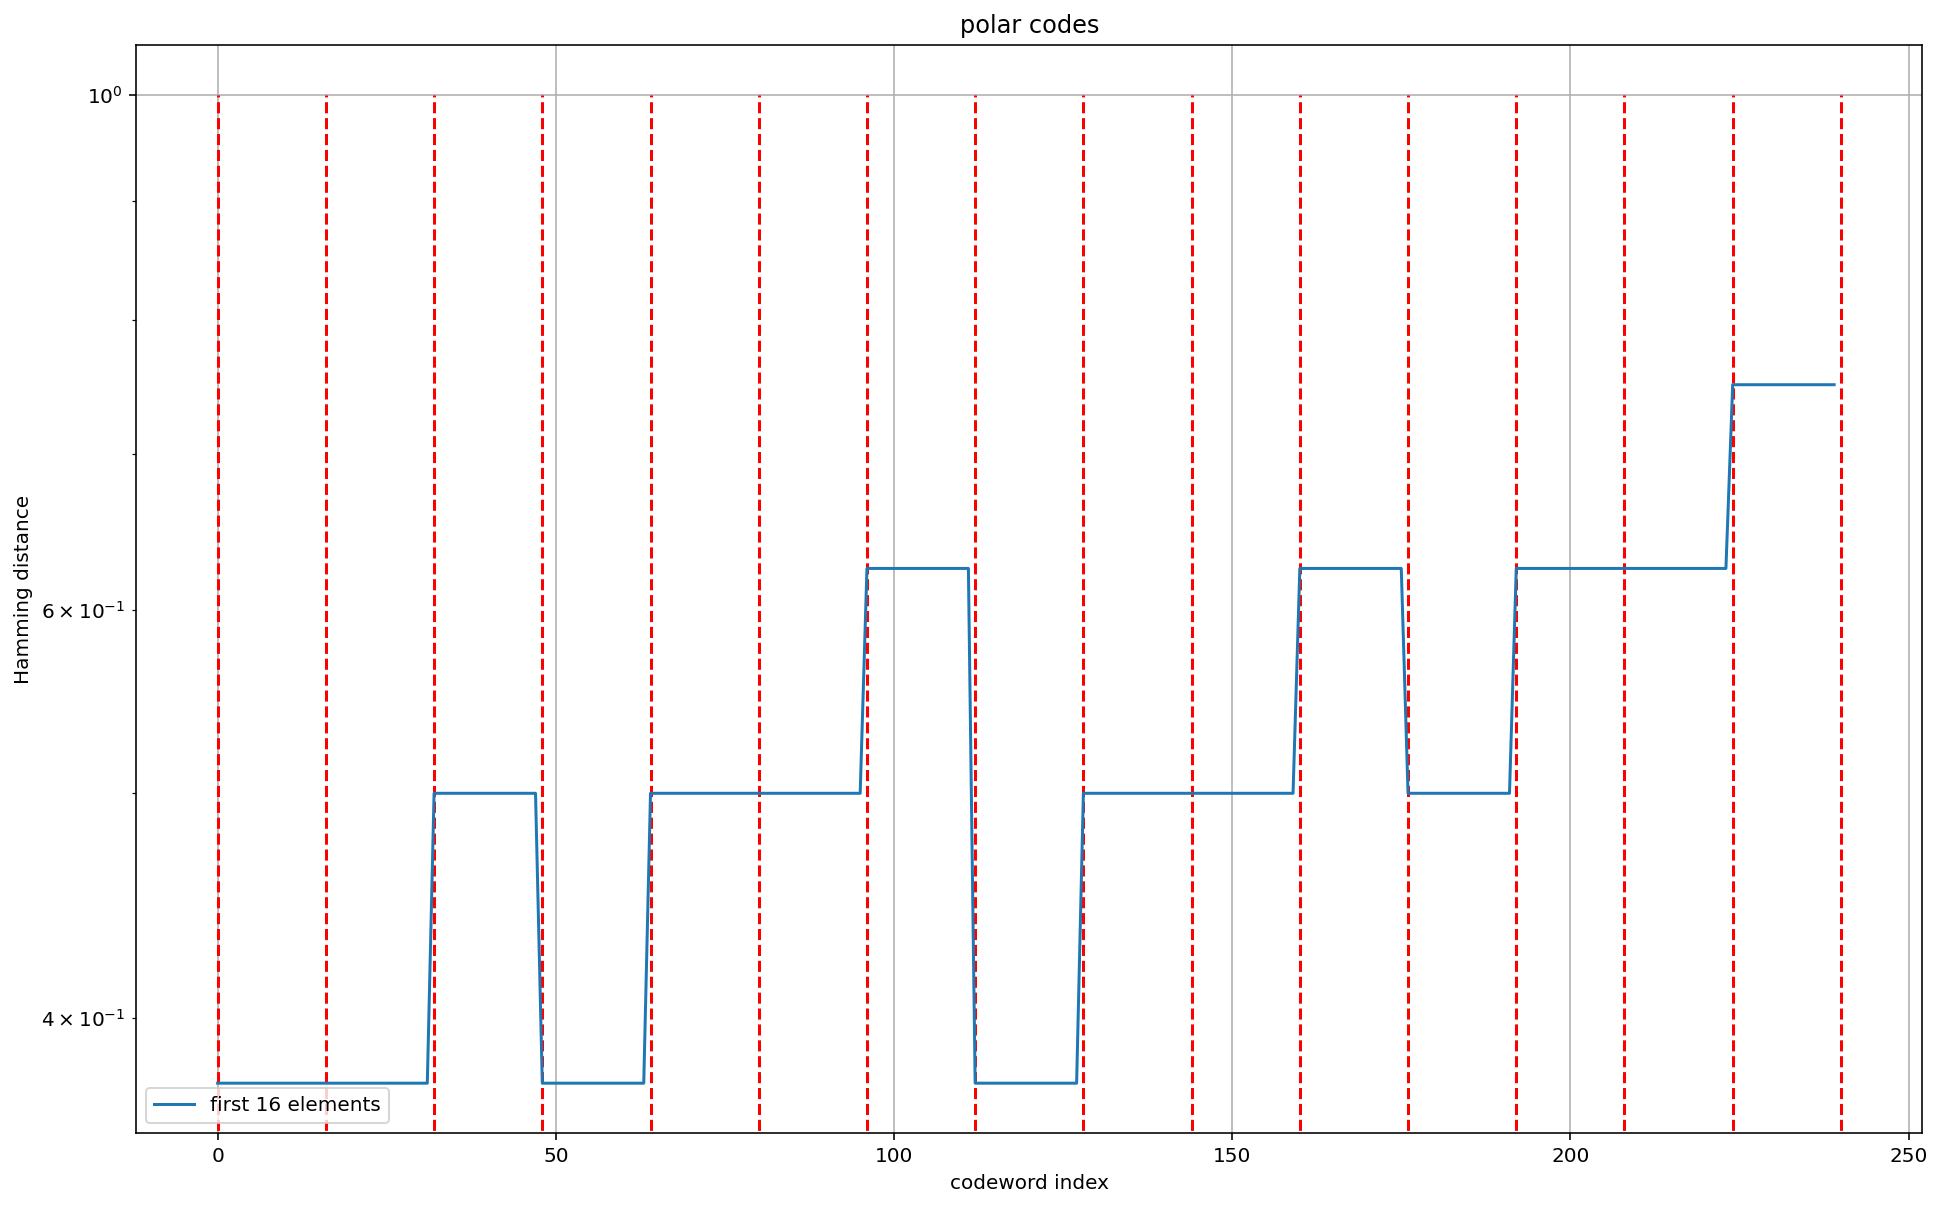

In [830]:
plt.figure(figsize = (16, 10))
plt.plot(dist)
plt.vlines([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240], 0, 1, linestyles='dashed', colors='red')
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('Hamming distance')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

<ipython-input-826-99cc794e70d9>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


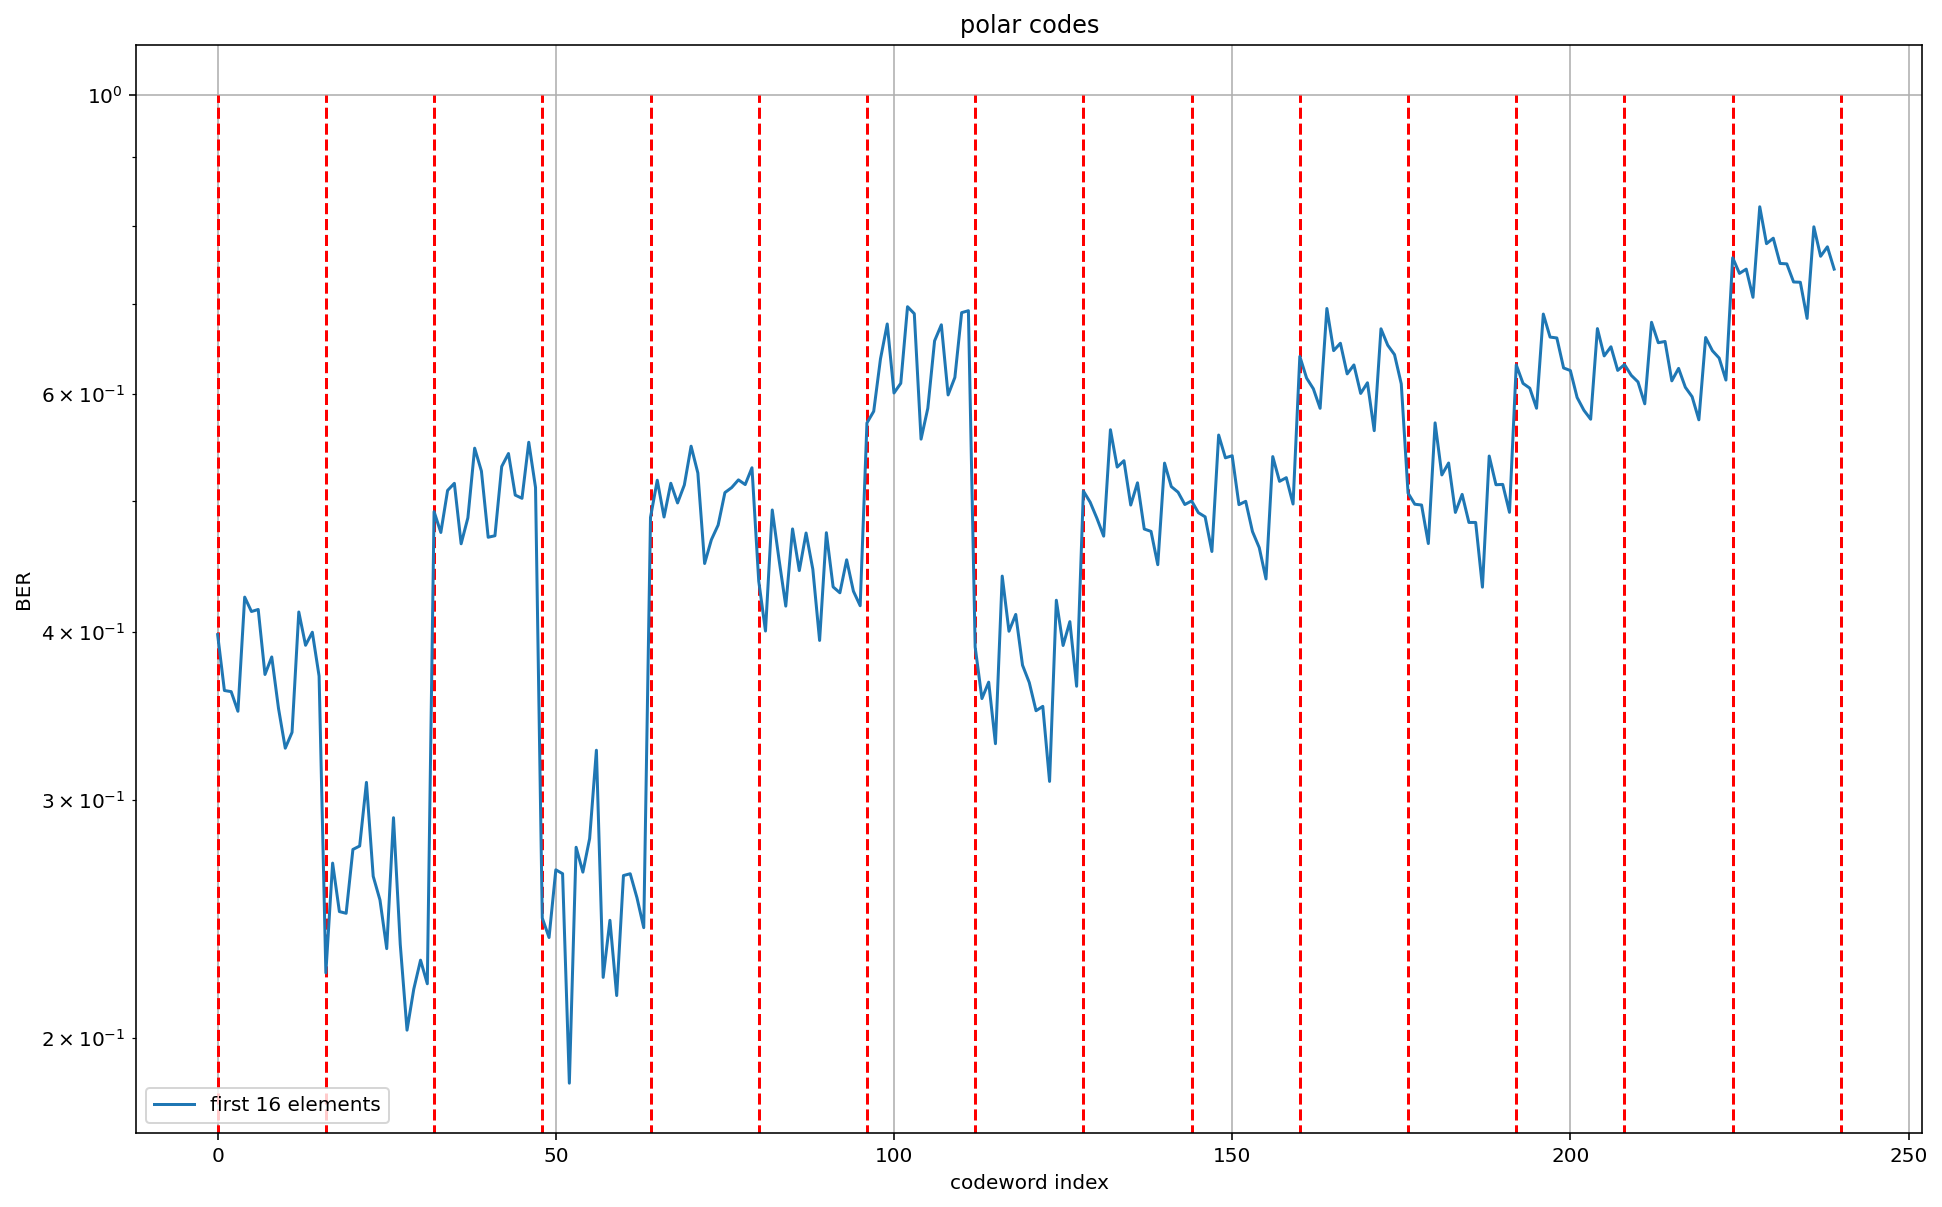

In [826]:
legend = []
plt.figure(figsize = (16, 10))
for experiment in [5]:
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
    legend.append(exp_descr[experiment])
plt.vlines([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240], 0, 1, linestyles='dashed', colors='red')
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

# Train NN on the information words basis (identity matrix)

### Sptit codebook on train / validation parts

In [858]:
idx = []
for i in range(0, k):
    idx.append(2**(i+1)-2**i)
print(f'training indices: {idx}')
inputs_train = inputs[idx]
codewords_train = codewords[idx]
d_test = np.delete(inputs, idx, axis=0)

training indices: [1, 2, 4, 8, 16, 32, 64, 128]


In [855]:
inputs[idx].astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]])

### Fit model

In [859]:
%%time
model, decoder = update_model('dense-128-64-32')
history = model.fit(codewords_train, inputs_train, batch_size=batch_size, epochs=nb_epoch,
                    shuffle=True, verbose=0, callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

CPU times: user 10min 14s, sys: 1min 23s, total: 11min 37s
Wall time: 8min


### Evaluate model

In [885]:
# Train on basis (identity matrix)
exp_descr.append('Train on basis (identity matrix)')                           # Add legend
nb_errors = np.append(nb_errors, np.zeros((1, 2**k, len(sigmas))), axis=0)     # Add row for new data
nb_bits = np.append(nb_bits, np.zeros((1, 2**k, len(sigmas))), axis=0)         # Add row for new data

for i in range(0,len(sigmas)):

    x_test = np.zeros((d_test.shape[0], N), dtype=bool)
    u_test = np.zeros((d_test.shape[0], N), dtype=bool)

    u_test[:, log_vector] = d_test
    for ii in range(0,d_test.shape[0]):

        print(f'Decoding SNR: {i+1}/{len(sigmas)}, CW: {ii+1}/{d_test.shape[0]}   ', end="\r")

        x_test[ii] = polar_transform_iter(u_test[ii])
        d_test_batch = np.tile(d_test[ii], (test_batch, 1))
        x_test_batch = np.tile(x_test[ii], (test_batch, 1))


        # Modulator (BPSK)
        s_test = -2*x_test_batch + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)


        nb_bits[nb_bits.shape[0]-1][ii][i] += d_test_batch.size
        nb_errors[nb_errors.shape[0]-1][ii][i] += decoder.evaluate(y_test, d_test_batch, batch_size=test_batch, verbose=0)[1]

### Make predictions

In [878]:
predictions = np.zeros((d_test.shape[0], k), dtype = bool)
u_test = np.zeros((d_test.shape[0], N), dtype=bool)
u_test[:, log_vector] = d_test
print(f'CW #,  predicted        |  inputs')
for i in range(0, u_test.shape[0]):
    x_test = polar_transform_iter(u_test[i])
    s_test = -2*x_test + 1
    y_test = s_test + sigmas[-1]*np.random.standard_normal(s_test.shape)
    predictions[i] = np.round(decoder.predict(np.reshape(y_test, (1, 16)), batch_size=1))
    print(f'CW:{i+inputs_train.shape[0]} {predictions[i].astype(int)} | {d_test[i].astype(int)}')

CW #,  predicted        |  inputs
CW:8 [0 0 0 0 1 0 0 0] | [0 0 0 0 0 0 0 0]
CW:9 [0 0 0 0 0 0 0 0] | [0 0 0 0 0 0 1 1]
CW:10 [0 0 0 0 0 0 0 0] | [0 0 0 0 0 1 0 1]
CW:11 [0 0 0 0 0 0 0 0] | [0 0 0 0 0 1 1 0]
CW:12 [0 0 0 0 1 0 0 0] | [0 0 0 0 0 1 1 1]
CW:13 [0 0 0 0 0 0 0 1] | [0 0 0 0 1 0 0 1]
CW:14 [0 0 0 0 0 0 1 0] | [0 0 0 0 1 0 1 0]
CW:15 [0 0 0 0 0 0 0 1] | [0 0 0 0 1 0 1 1]
CW:16 [0 1 0 0 0 0 0 0] | [0 0 0 0 1 1 0 0]
CW:17 [0 0 0 0 0 0 0 1] | [0 0 0 0 1 1 0 1]
CW:18 [0 0 0 0 0 0 1 0] | [0 0 0 0 1 1 1 0]
CW:19 [0 0 0 0 0 0 0 0] | [0 0 0 0 1 1 1 1]
CW:20 [0 0 0 0 0 0 0 0] | [0 0 0 1 0 0 0 1]
CW:21 [0 0 0 0 0 0 0 0] | [0 0 0 1 0 0 1 0]
CW:22 [0 0 1 0 0 0 0 0] | [0 0 0 1 0 0 1 1]
CW:23 [0 0 0 0 0 0 0 0] | [0 0 0 1 0 1 0 0]
CW:24 [0 1 0 0 0 0 0 0] | [0 0 0 1 0 1 0 1]
CW:25 [0 0 0 0 0 0 0 0] | [0 0 0 1 0 1 1 0]
CW:26 [0 0 0 0 0 1 0 0] | [0 0 0 1 0 1 1 1]
CW:27 [0 0 0 1 0 0 0 0] | [0 0 0 1 1 0 0 0]
CW:28 [0 0 0 0 0 0 0 1] | [0 0 0 1 1 0 0 1]
CW:29 [0 1 0 0 0 0 0 0] | [0 0 0 1 1 0 1 0]


In [882]:
test = np.array([], dtype=int)
for current_input in inputs_train:
    test = np.append(test, (np.where((predictions == current_input).all(axis=1))[0]+inputs_train.shape[0]))
print('indicies of predicted codewords which exist in train set:')
print(np.sort(test))
print('indicies of zero-codewords:')
print(np.where((predictions == np.zeros(8)).all(axis=1))[0]+inputs_train.shape[0])

indicies of predicted codewords which exist in train set:
[  8  12  13  14  15  16  17  18  22  24  26  27  28  29  31  35  36  37
  38  40  42  43  44  45  46  48  49  50  51  52  54  57  58  60  61  64
  65  66  67  69  70  71  73  74  78  79  80  81  82  83  85  88  89  92
  93  94  95  96  97  98  99 101 104 105 107 108 109 110 112 113 114 115
 116 117 118 119 120 121 122 124 125 126 127 131 132 133 134 136 138 140
 142 143 144 147 148 149 152 154 155 156 157 160 161 162 163 167 168 169
 170 171 173 175 176 177 178 179 180 181 182 183 185 186 188 190 191 192
 193 196 197 198 199 200 203 204 208 210 211 212 213 214 215 218 220 223
 224 225 227 229 230 231 233 234 235 236 238 240 241 243 245 246 247 248
 251 252 254 255]
indicies of zero-codewords:
[  9  10  11  19  20  21  23  25  30  32  33  34  39  41  47  53  55  56
  59  62  68  72  75  76  77  84  86  87  90  91 100 102 103 106 111 128
 129 130 135 137 139 141 145 146 150 151 153 158 159 164 165 166 172 174
 184 187 189 194 195

NN is able to predict words from train set and zero-codeword. NN can not construct codewords with more, than one non-zero bit, if the train set is an identity matrix

## Plot graph of the average Hamming distance for the every CW in the test set

In [883]:
dist = np.zeros(predictions.shape[0], dtype=float)
for i, cw in enumerate(d_test):
    for current_input in inputs_train:
        dist[i] += distance.hamming(cw, current_input)
dist /= inputs_train.shape[0]
dist

array([0.125  , 0.3125 , 0.3125 , 0.3125 , 0.40625, 0.3125 , 0.3125 ,
       0.40625, 0.3125 , 0.40625, 0.40625, 0.5    , 0.3125 , 0.3125 ,
       0.40625, 0.3125 , 0.40625, 0.40625, 0.5    , 0.3125 , 0.40625,
       0.40625, 0.5    , 0.40625, 0.5    , 0.5    , 0.59375, 0.3125 ,
       0.3125 , 0.40625, 0.3125 , 0.40625, 0.40625, 0.5    , 0.3125 ,
       0.40625, 0.40625, 0.5    , 0.40625, 0.5    , 0.5    , 0.59375,
       0.3125 , 0.40625, 0.40625, 0.5    , 0.40625, 0.5    , 0.5    ,
       0.59375, 0.40625, 0.5    , 0.5    , 0.59375, 0.5    , 0.59375,
       0.59375, 0.6875 , 0.3125 , 0.3125 , 0.40625, 0.3125 , 0.40625,
       0.40625, 0.5    , 0.3125 , 0.40625, 0.40625, 0.5    , 0.40625,
       0.5    , 0.5    , 0.59375, 0.3125 , 0.40625, 0.40625, 0.5    ,
       0.40625, 0.5    , 0.5    , 0.59375, 0.40625, 0.5    , 0.5    ,
       0.59375, 0.5    , 0.59375, 0.59375, 0.6875 , 0.3125 , 0.40625,
       0.40625, 0.5    , 0.40625, 0.5    , 0.5    , 0.59375, 0.40625,
       0.5    , 0.5 

Result is predictable.
NN is not constructing CWs with more, than one non-zero bit. As the codeword index increases, the average number of non-zero bits in the codeword increases as well. The Hamming distance increases accordingly.

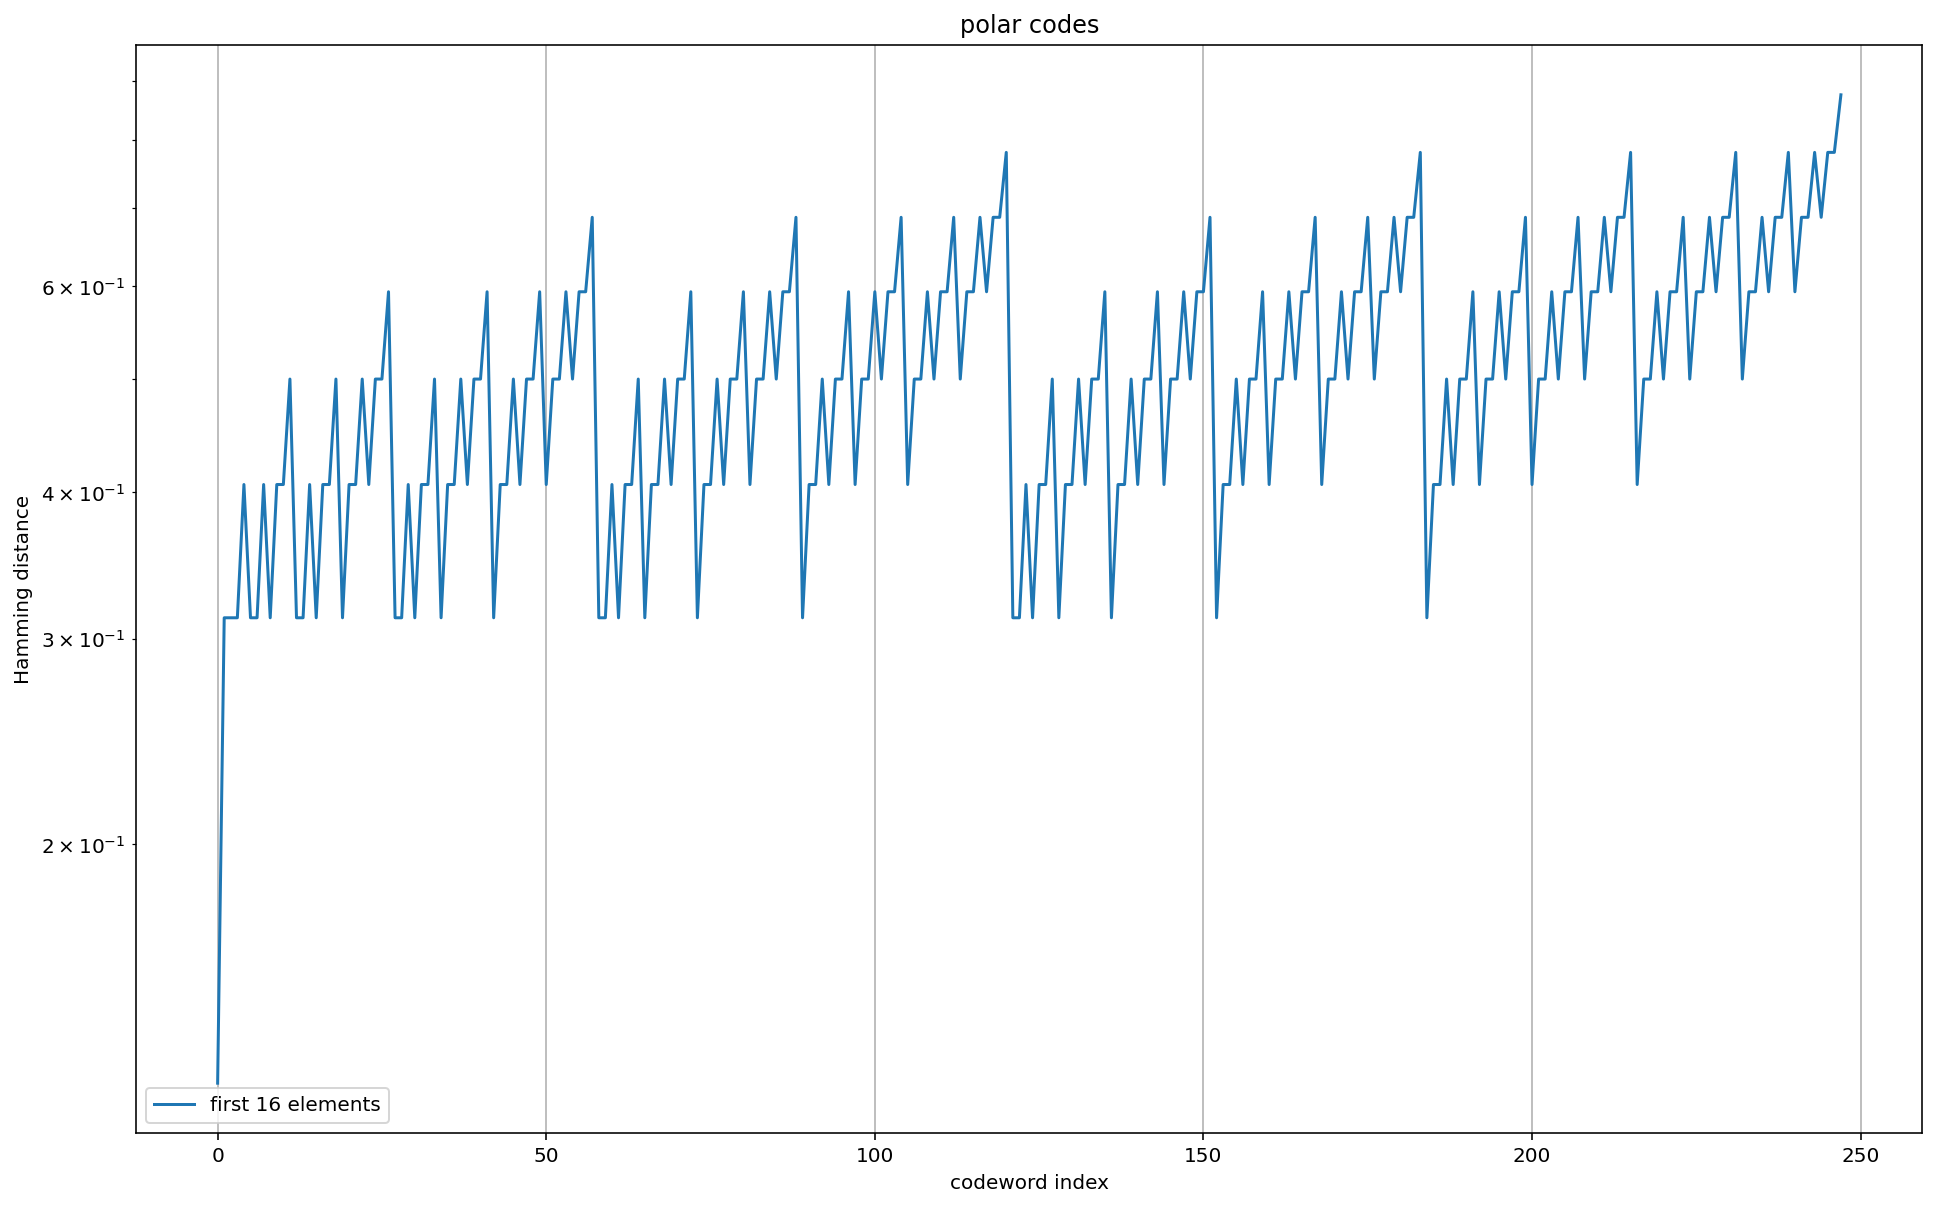

In [886]:
plt.figure(figsize = (16, 10))
plt.plot(dist)
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('Hamming distance')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

<ipython-input-893-80509f381ca7>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


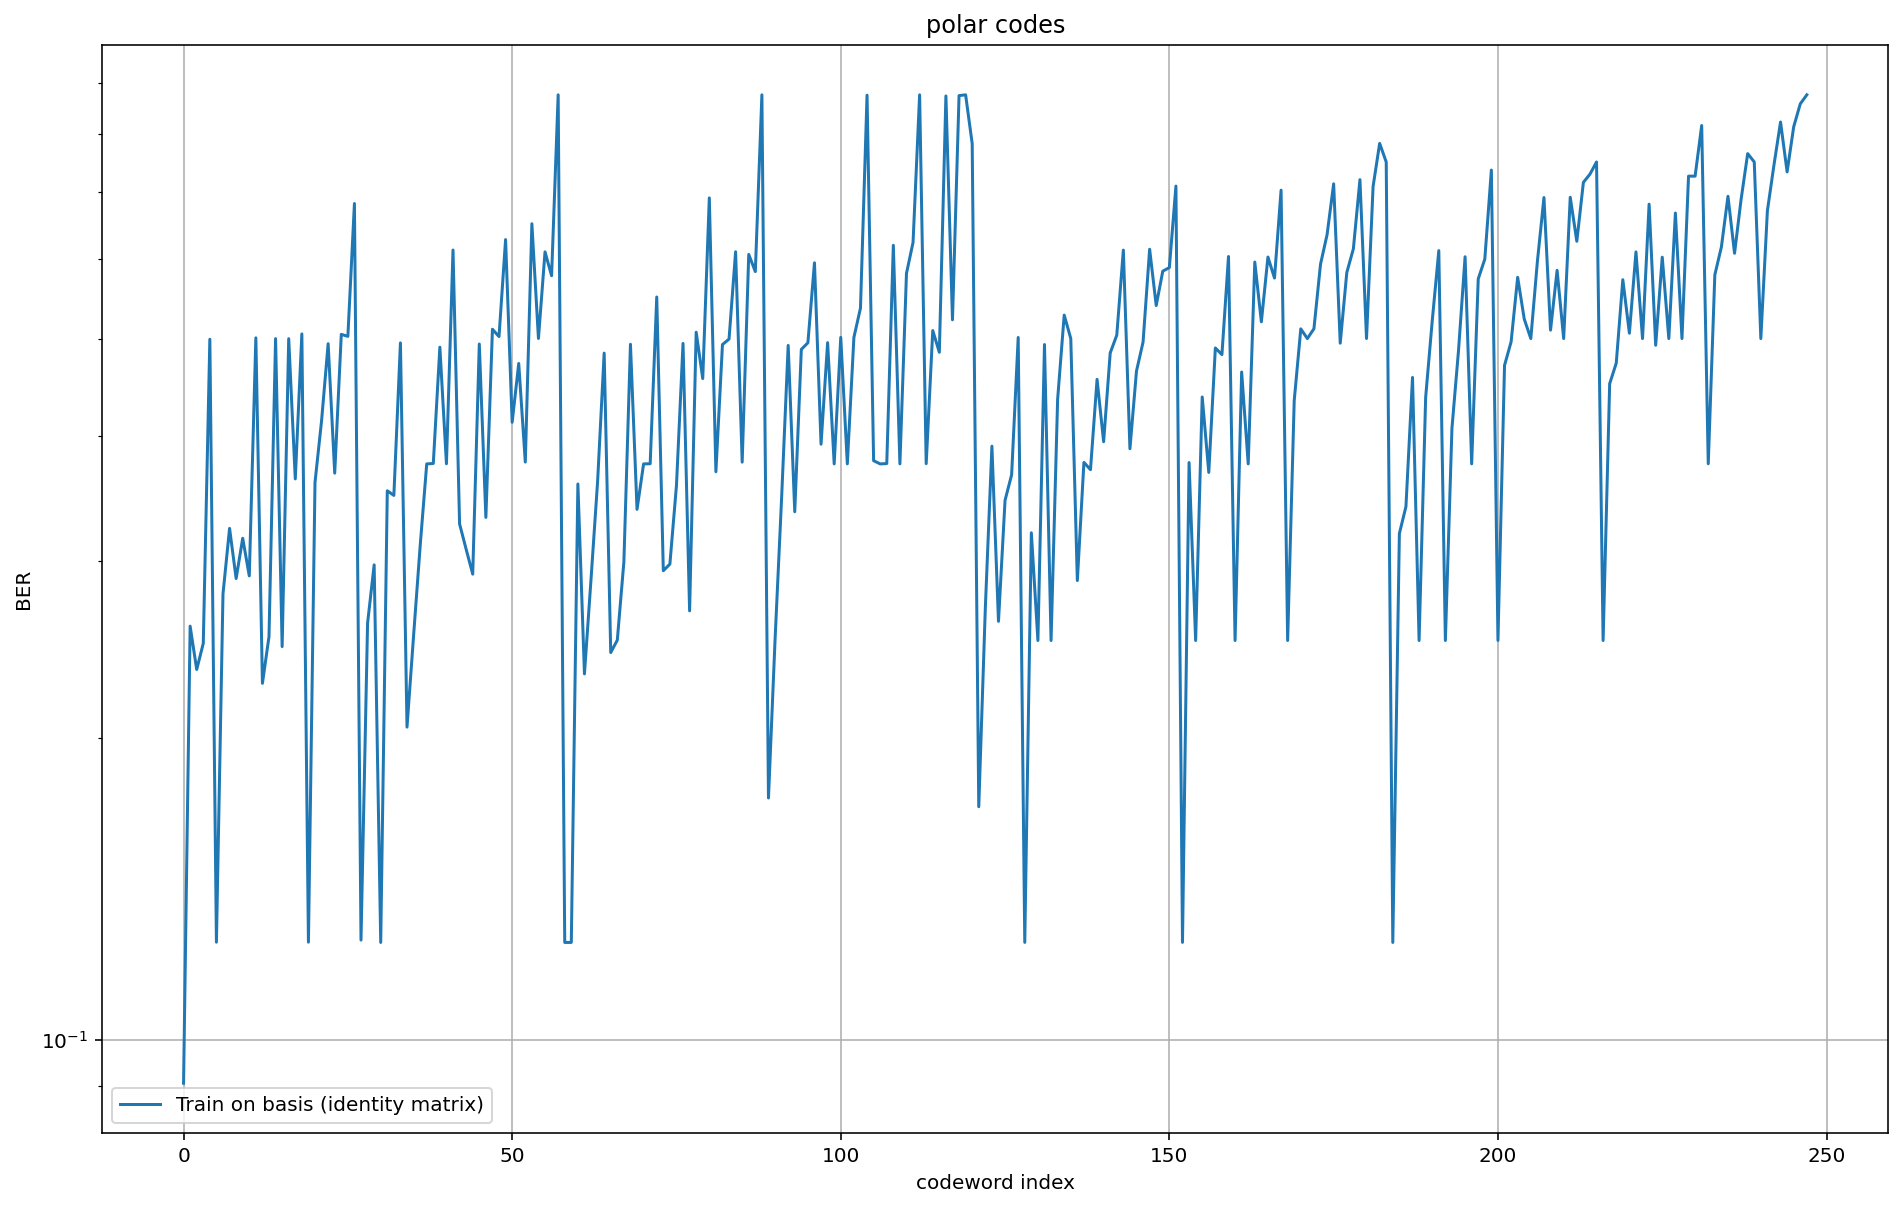

In [893]:
legend = []
plt.figure(figsize = (16, 10))

for experiment in [14]:
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
    legend.append(exp_descr[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

# Iterative picking. Train set size - 86

In [912]:
inputs_train.shape, d_test.shape

((86, 8), (170, 8))

### Make predictions

In [933]:
predictions = np.zeros((d_test.shape[0], k), dtype = bool)
u_test = np.zeros((d_test.shape[0], N), dtype=bool)
u_test[:, log_vector] = d_test
print(f'CW #,  predicted        |  inputs')
for i in range(0, u_test.shape[0]):
    x_test = polar_transform_iter(u_test[i])
    s_test = -2*x_test + 1
    y_test = s_test + sigmas[-1]*np.random.standard_normal(s_test.shape)
    predictions[i] = np.round(decoder.predict(np.reshape(y_test, (1, 16)), batch_size=1))
    print(f'CW:{i+inputs_train.shape[0]} {predictions[i].astype(int)} | {d_test[i].astype(int)}')

CW #,  predicted        |  inputs
CW:86 [0 1 0 0 0 0 0 1] | [0 0 0 0 0 0 0 1]
CW:87 [0 1 1 1 0 1 1 0] | [0 0 0 0 0 0 1 0]
CW:88 [0 1 0 1 0 0 0 1] | [0 0 0 0 0 1 0 0]
CW:89 [0 1 1 0 0 1 1 1] | [0 0 0 0 0 1 0 1]
CW:90 [0 1 0 1 1 1 0 1] | [0 0 0 0 0 1 1 1]
CW:91 [0 1 0 0 1 0 0 0] | [0 0 0 0 1 0 0 0]
CW:92 [0 1 0 0 1 1 1 0] | [0 0 0 0 1 0 1 0]
CW:93 [0 1 0 1 0 0 0 1] | [0 0 0 0 1 0 1 1]
CW:94 [0 1 1 1 0 1 0 1] | [0 0 0 0 1 1 0 1]
CW:95 [0 1 0 0 0 0 1 0] | [0 0 0 0 1 1 1 0]
CW:96 [0 1 0 0 0 1 0 1] | [0 0 0 1 0 0 0 0]
CW:97 [0 0 0 1 1 0 0 1] | [0 0 0 1 0 0 0 1]
CW:98 [0 1 0 1 0 0 1 1] | [0 0 0 1 0 0 1 1]
CW:99 [0 0 0 1 1 0 0 0] | [0 0 0 1 0 1 0 0]
CW:100 [0 0 1 1 1 1 1 0] | [0 0 0 1 0 1 1 0]
CW:101 [0 0 0 1 1 0 1 0] | [0 0 0 1 0 1 1 1]
CW:102 [0 1 0 1 0 1 0 1] | [0 0 0 1 1 0 0 1]
CW:103 [0 0 0 1 0 0 0 0] | [0 0 0 1 1 0 1 0]
CW:104 [0 0 1 1 0 1 0 0] | [0 0 0 1 1 1 0 0]
CW:105 [0 1 1 1 1 0 1 1] | [0 0 0 1 1 1 0 1]
CW:106 [0 1 0 1 0 1 1 1] | [0 0 0 1 1 1 1 1]
CW:107 [0 1 1 0 0 1 0 0] | [0 0 1 0

In [934]:
test = np.array([], dtype=int)
for current_input in inputs_train:
    test = np.append(test, (np.where((predictions == current_input).all(axis=1))[0]+inputs_train.shape[0]))
print('indicies of predicted codewords which exist in train set:')
print(np.sort(test))

indicies of predicted codewords which exist in train set:
[ 88  90  91  92  93  94  95  96  99 105 106 108 111 114 116 119 122 124
 127 128 129 130 131 134 135 136 137 138 139 141 143 146 147 148 149 150
 152 154 155 157 160 161 162 163 164 167 172 173 174 177 179 180 181 182
 186 187 188 192 195 197 201 204 207 208 210 212 214 215 216 217 221 222
 229 232 241 243 244 246 248 250 251 253]


In [947]:
test = np.array([], dtype=int)
for current_input in d_test:
    test = np.append(test, (np.where((predictions == current_input).all(axis=1))[0]+inputs_train.shape[0]))
print('indicies of predicted codewords which DOES NOT exist in train set:')
print(np.sort(test))

indicies of predicted codewords which DOES NOT exist in train set:
[ 86  87  89  97  98 100 101 102 103 104 107 109 110 112 113 115 117 118
 120 121 123 125 126 132 133 140 142 144 145 151 153 156 158 159 165 166
 168 169 170 171 175 176 178 183 184 185 189 190 191 193 194 196 198 199
 200 202 203 205 206 209 211 213 218 219 220 223 224 225 226 227 228 230
 231 233 234 235 236 237 238 239 240 242 245 247 249 252 254 255]


In [946]:
for i in range(0, d_test.shape[0]):
    if ((predictions[i] == d_test[i]).all(axis=0)):
        print(i+inputs_train.shape[0])

230
238


NN can construct unseen codewords. Only two unseen codewords were predicted correctly

## Plot graph of the average Hamming distance for the every CW in the test set

In [948]:
dist = np.zeros(predictions.shape[0], dtype=float)
for i, cw in enumerate(d_test):
    for current_input in inputs_train:
        dist[i] += distance.hamming(cw, current_input)
dist /= inputs_train.shape[0]
dist

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5])

CWs are selected eevnly across all codebook and the result is averaged by 86 train set elements

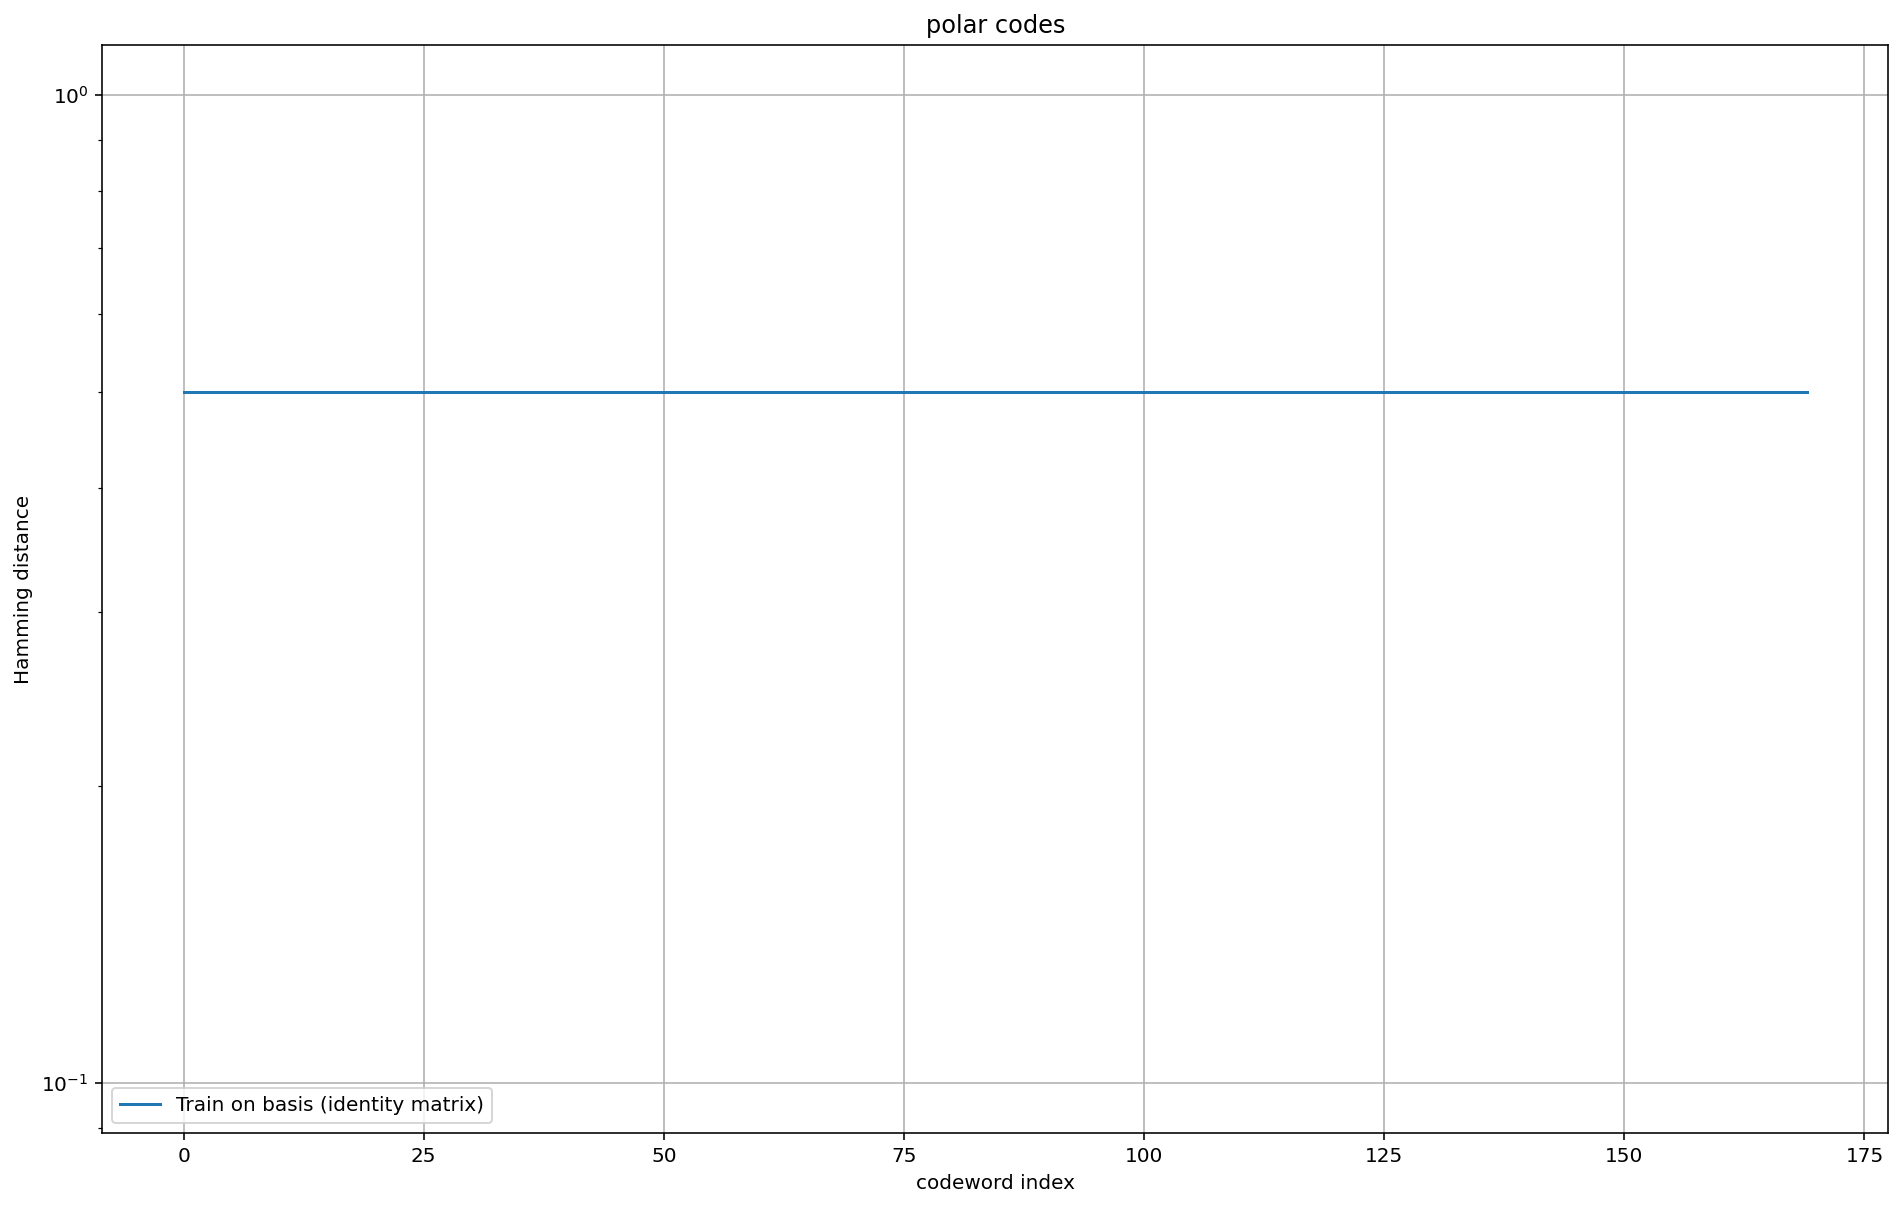

In [949]:
plt.figure(figsize = (16, 10))
plt.plot(dist)
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('Hamming distance')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

<ipython-input-951-b85fd1dd6056>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])


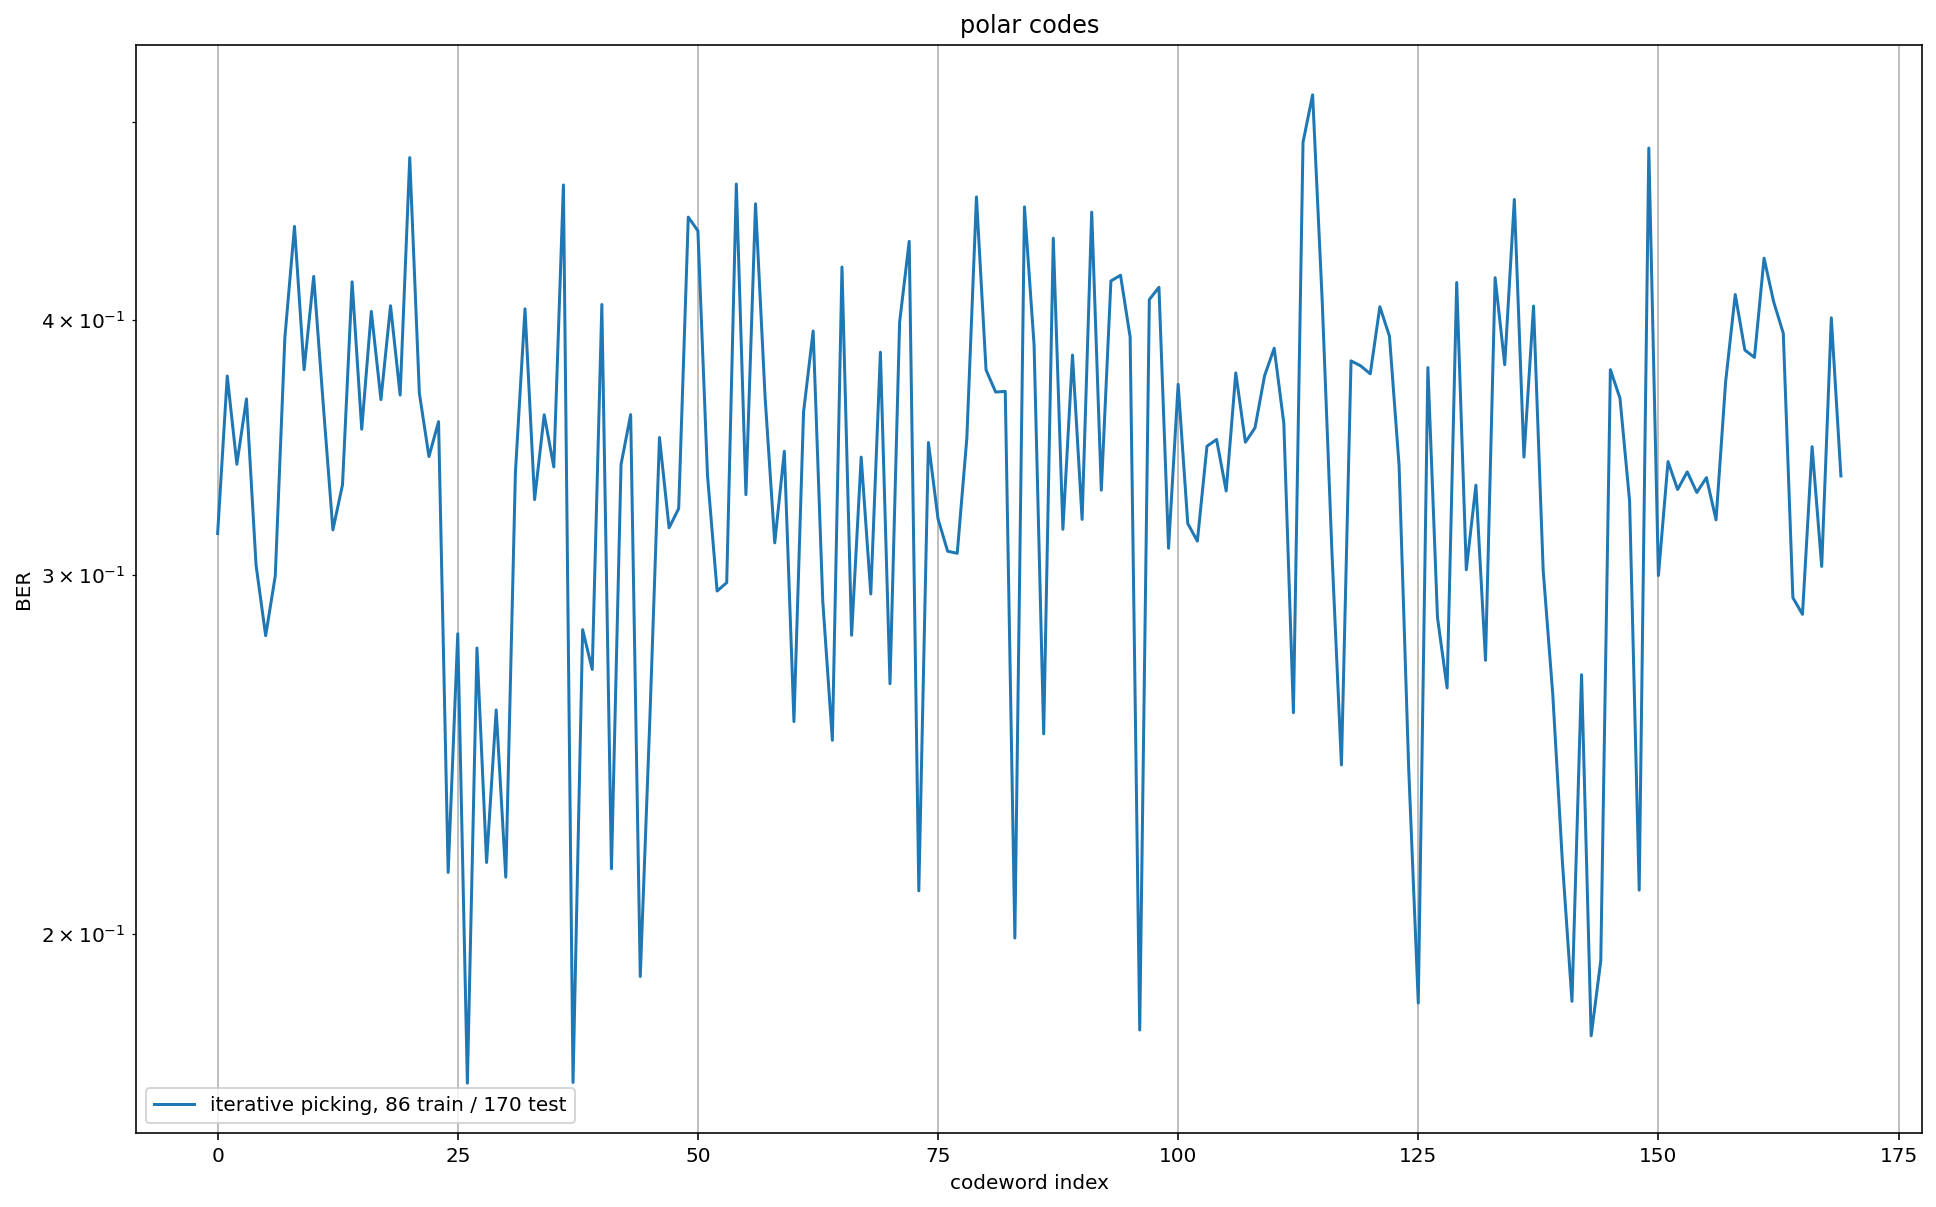

In [951]:
legend = []
plt.figure(figsize = (16, 10))

for experiment in [3]:
    plt.plot(nb_errors[experiment,:,-1]/nb_bits[experiment,:,-1])
    legend.append(exp_descr[experiment])
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('codeword index')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()